<a href="https://colab.research.google.com/github/princessivy/Analyzing_CSGO_SkinPrices/blob/main/CSGO_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd
import requests
import json

from google.colab import drive
from pathlib import Path

from PIL import Image
import requests
import cv2
import numpy as np

import time

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
#%reload_ext autoreload
#%autoreload 2

#Daten einlesen

In [2]:
data = pd.read_csv(r'/content/drive/MyDrive/SA_BA/Data/allitems_w_colors.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.head()

,id,saleId,productId,assetId,itemId,appid,steamid,url,family,family_localized,...,collection,collection_localized,stickers,canHaveScreenshots,screenshots,souvenir,stattrak,tags,ownItem,colorfulness
0,0,6909421,5523872,46917102,9191,730,76561198837929747,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,59.790243
1,0,7653740,6120295,60753316,10318,730,76561198837492108,stattrak-bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,True,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,57.181995
2,0,6835166,5463330,55716802,9191,730,76561198838929253,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,58.160273
3,0,5746569,4614623,43496004,9191,730,76561198837990201,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,58.489647
4,0,7664927,6129355,60829717,9191,730,76561198837298247,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,60.797777


#Beschreibung der Features
Der rohe Datensatz enthält die folgenden Features:

In [ ]:
data.columns

Index(['id', 'saleId', 'productId', 'assetId', 'itemId', 'appid', 'steamid',
       'url', 'family', 'family_localized', 'name', 'title', 'text',
       'marketName', 'marketHashName', 'color', 'bgColor', 'image', 'classid',
       'assetid', 'lock', 'version', 'versionType', 'stackAble',
       'suggestedPrice', 'salePrice', 'currency', 'saleStatus', 'saleType',
       'category', 'category_localized', 'subCategory',
       'subCategory_localized', 'pattern', 'finish', 'customName', 'wear',
       'link', 'type', 'exterior', 'quality', 'rarity', 'rarity_localized',
       'rarityColor', 'collection', 'collection_localized', 'stickers',
       'canHaveScreenshots', 'screenshots', 'souvenir', 'stattrak', 'tags',
       'ownItem', 'colorfulness'],
      dtype='object')

Folgende Tabelle erklärt die Bedeutung der einzelnen Features:

Feature | Bedeutung
--- | ---
id | keine Angabe - ist stetig '0'
saleId | eindeutige Verkaufs-ID
productId | eindeutige Produkt-ID
assetId | eindeutige Asset-ID
itemId| itemspezifische ID
appid | Zuordnung zur Applikation CS:GO - ist stetig '730'
steamid | ID auf steamcommunity.com
url | spezifischer Bestandteil der gesamten URL für das Item
family | zugehörige Familie des Items (Unterunterkategorie)
family_localized | wie 'family' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
name | Anzeigename auf Skinport
title | angezeigte Unterkategorie zu jedem Item
text | kurze Beschreibung zum Item
marketName | Zusammensetzung aus 'title' und 'name'
marketHashName | keine Angabe - ähnlich zu 'marketName'
color | keine Angabe - sind vier Farbcodes
bgColor | keine Angabe - ist stetig 'NaN'
image | mit Ergänzung "https://steamcommunity-a.akamaihd.net/economy/image/" vor dem Wert, gelangt man an ein standardisiertes Cover-Bild des Items
classid | keine Angabe
assetid | weitere eindeutige Asset-ID
lock | Zeigt, ab wann Item zum Spieleinsatz freigegeben ist ('NaN' bedeutet, dass ein direkter Einsatz möglich ist)
version | verschiedene Versionen der Skins
versionType | Zuordnung der 'version's in übergeordnete Kategorie
stackAble | keine Angabe - ist stetig 'False'
suggestedPrice | Wertvorschlag des Preises eines Skins von Skinport
salePrice | Kaufpreis des Items, angegeben durch den Verkäufer
currency | Währung - ist stetig 'EUR'
saleStatus | gibt an, ob Item verkaufbar ist - ist stetig 'listed' und somit verkaufbar
saleType | gibt an, wer einen Kauf machen kann - ist stetig 'public' und somit für alle zugänglich
category | Überkategorie
category_localized | wie 'category' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
subCategory | Unterkategorie
subCategory_localized | wie 'subCategory' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
pattern | Musternummer des Items (zwischen 1 und 1000)
finish | Finish des Items
customName | Name des Items, hinzugefügt durch einen Besitzer
wear | Abnutzung (zwischen 0 und 1)
link | keine Angabe
type | Typ des Items
exterior | Kategorie der Abnutzung, je nach 'wear'
quality | Kategorie der Qualität
rarity | Kategorie der Rarität
rarity_localized | wie 'rarity' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
rarityColor | Farbkategorie der Rarität
collection | Kollektion 
collection_localized | wie 'collection' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
stickers | Array mit Stickern, welche sich auf dem Item befinden
canHaveScreenshots | gibt an, ob Screenshots zum Item existieren - ist stetig 'True'
screenshots | gibt an, welche Screenshots zum Item existieren
souvenir | gibt an, ob das Item ein Souvenir ist oder nicht
stattrak | gibt an, ob das Item Stattrak-Eigenschaft hat oder nicht
tags | angegebene Tags auf Skinport
ownItem | gibt an, ob das Item unter Besitz steht - ist stetig 'False'
colorfulness | gibt die Farbintensität eines Skins an - umso höher, desto farbiger (Feature wurde zuvor berechnet)

Entfernung der Features, welche keinen erkärenden oder nützlichen Mehrwert liefern:

In [3]:
data = data.drop(['id', 'saleId', 'productId', 'itemId', 'appid', 'steamid', 'url', 'family_localized', 'name', 'title', 'text', 'marketName', 'marketHashName', 'bgColor',
                  'image', 'classid', 'assetid', 'stackAble', 'currency', 'saleStatus', 'saleType', 'category_localized', 'subCategory_localized',
                  'customName', 'link', 'rarity_localized', 'collection_localized', 'canHaveScreenshots', 'screenshots', 'tags', 'ownItem'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
data.columns

Index(['assetId', 'family', 'color', 'lock', 'version', 'versionType',
       'suggestedPrice', 'salePrice', 'category', 'subCategory', 'pattern',
       'finish', 'wear', 'type', 'exterior', 'quality', 'rarity',
       'rarityColor', 'collection', 'stickers', 'souvenir', 'stattrak',
       'colorfulness'],
      dtype='object')

In [5]:
len(data.columns) #Anzahl aktueller Features nach erster Bereinigung

23

#Explorative Datenanalyse
Erster Eindruck über die Daten:

In [ ]:
data.head()

,assetId,family,color,lock,version,versionType,suggestedPrice,salePrice,category,subCategory,...,type,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness
0,46917102,Tiger Tooth,#8650AC,NaN,default,default,39721,39913,Knife,Bayonet,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,59.790243
1,60753316,Tiger Tooth,#8650AC,2022-04-02T07:00:00.000Z,default,default,44203,36244,Knife,Bayonet,...,★ StatTrak™ Covert Knife,Factory New,★ StatTrak™,Covert,#eb4b4b,NaN,[],False,True,57.181995
2,55716802,Tiger Tooth,#8650AC,NaN,default,default,39721,40000,Knife,Bayonet,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,58.160273
3,43496004,Tiger Tooth,#8650AC,NaN,default,default,39721,42073,Knife,Bayonet,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,58.489647
4,60829717,Tiger Tooth,#8650AC,2022-04-03T07:00:00.000Z,default,default,39721,35500,Knife,Bayonet,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,60.797777


Datentypen angucken. Wichtige Unterscheidung zwischen nummerischen und kategorialen Features:

In [ ]:
data.dtypes

assetId             int64
family             object
color              object
lock               object
version            object
versionType        object
suggestedPrice      int64
salePrice           int64
category           object
subCategory        object
pattern           float64
finish            float64
wear              float64
type               object
exterior           object
quality            object
rarity             object
rarityColor        object
collection         object
stickers           object
souvenir             bool
stattrak             bool
colorfulness      float64
dtype: object

Nummerisch:
- assetId
- suggestedPrice
- salePrice
- pattern
- finish
- wear
- colorfulness

Kategorisch:
- family
- color
- lock
- version
- versionType
- category
- subCategory
- type
- exterior
- quality
- rarity
- rarityColor
- collection
- stickers
- souvenir
- stattrak


##Handhabung Missing-Values

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133005 entries, 0 to 133004
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   assetId         133005 non-null  int64  
 1   family          133005 non-null  object 
 2   color           133005 non-null  object 
 3   lock            29404 non-null   object 
 4   version         133005 non-null  object 
 5   versionType     133005 non-null  object 
 6   suggestedPrice  133005 non-null  int64  
 7   salePrice       133005 non-null  int64  
 8   category        133005 non-null  object 
 9   subCategory     133005 non-null  object 
 10  pattern         132989 non-null  float64
 11  finish          132838 non-null  float64
 12  wear            133005 non-null  float64
 13  type            133005 non-null  object 
 14  exterior        133005 non-null  object 
 15  quality         133005 non-null  object 
 16  rarity          133005 non-null  object 
 17  rarityColo

In [ ]:
data.shape

(133005, 23)

In [ ]:
data = data.drop_duplicates()

In [ ]:
data.shape #es gibt keine Duplikate

(133005, 23)

In [ ]:
data.isnull().sum()

assetId                0
family                 0
color                  0
lock              103601
version                0
versionType            0
suggestedPrice         0
salePrice              0
category               0
subCategory            0
pattern               16
finish               167
wear                   0
type                   0
exterior               0
quality                0
rarity                 0
rarityColor            0
collection          4680
stickers               0
souvenir               0
stattrak               0
colorfulness           0
dtype: int64

In den Features *lock, pattern, finish* und *collection* finden sich Null-Werte. Diese werden nun behandelt. 

**lock** Bei *lock* geht es darum, ob die Items nach dem Kauf direkt zum Spiel einsetzbar sind. Ist ein Skin im Lock, muss erst die Zeit abgewartet werden, bis das Skin einsatzfähig ist. Ein 'NaN' steht bezüglich der Eigenschaft Lock in diesem Fall für "nein"(0), eine Zeitangabe für "ja"(1). Entsprechend entsteht hieraus ein Boolean.  
(Dauer: 2 Minuten)

In [ ]:
for x in range(len(data)):
  try:
    if np.isnan(data.lock[x]):
      data.lock[x] = 0
  except:
    data.lock[x] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**pattern** Die fehlenden Werte lassen sich hier nicht einfach durch Binarisierung oder Imputation lösen. Solche Annahmen über das Pattern würden die Daten eher verfälschen. Da es sich bei den 16 fehlenden Werten um einen Anteil von 0,012% handelt, werden diese hiermit aus dem Datensatz entfernt.

In [ ]:
data.shape

(133005, 23)

In [ ]:
data = data[data['pattern'].notna()]

In [ ]:
data.shape

(132989, 23)

**finish** Selbes Vorgehen wie bei *pattern*. Der Anteil, gemessen an der neuen Datenbasis, liegt bei 0,126%.

In [ ]:
data = data[data['finish'].notna()]

In [ ]:
data.shape

(132822, 23)

In [ ]:
#Index wieder richten
data = data.reset_index()

**collection** Die Items, die keiner Kollektion zugeordnet sind, werden zur Kollektion "No Collection" umbenannt und bilden somit eine weitere Ausprägung.

In [ ]:
 data['collection'] = data['collection'].fillna("No Collection")

##Datentypenanpassung
*suggestedPrice* und *salePrice* sollten float's sein. Die Trennung zwischen Euros und Cents fehlt. Diese Variablen werden durch 100 geteilt, um dies zu lösen:

In [ ]:
data['salePrice'] = data['salePrice']/100
data['suggestedPrice'] = data['suggestedPrice']/100

*pattern* liegt zwischen 1 und 1000. Dabei handelt es sich nicht um einen float-Wert. Dieser Wert wird auf int gecastet.

In [ ]:
data = data.astype({"pattern": int})

*finish* ist ebenso ein float, welcher eigentlich einem int enstpricht. Deshalb Casting.

In [ ]:
data = data.astype({"finish": int})

Um das Feature *stickers* richtig zu verarbeiten, wird dieses zu einer boolschen Variable umgeschrieben. Sticker: Ja(1) oder Nein(0).  
(Dauer: 2 Minuten, 30 Sekunden)

In [ ]:
for x in range(len(data)):
  if data.stickers[x] == '[]':
    data.stickers[x] = 0
  else:
    data.stickers[x] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


*souvenir* steht aktuell auf "True" oder "False". Hier wird eine Umformung in 0 und 1 vorgenommen. Das selbe gilt für *stattrak*.

In [ ]:
#souvenir
data["souvenir"] = data["souvenir"].astype(int)

#stattrak
data["stattrak"] = data["stattrak"].astype(int)

##Aktuelle Übersicht der Daten (inkl. Zwischenspeicherpunkt + Erweiterung um ein Feature)

**Übersicht**

In [ ]:
data.describe()

,index,assetId,lock,suggestedPrice,salePrice,pattern,finish,wear,stickers,souvenir,stattrak,colorfulness
count,132822.000000,1.328220e+05,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000
mean,66580.896501,4.724622e+07,0.220423,29.443286,34.422234,500.392533,647.262283,0.255292,0.179104,0.063988,0.099991,14.713770
std,38352.754248,1.329716e+07,0.414533,202.335509,372.976511,288.729975,1106.288792,0.177134,0.383441,0.244732,0.299989,11.226566
min,0.000000,1.240700e+04,0.000000,0.030000,0.020000,0.000000,2.000000,0.000007,0.000000,0.000000,0.000000,0.997502
25%,33377.250000,3.878514e+07,0.000000,0.030000,0.030000,250.000000,136.000000,0.125445,0.000000,0.000000,0.000000,7.197160
50%,66583.500000,5.176906e+07,0.000000,0.100000,0.120000,500.000000,611.000000,0.223606,0.000000,0.000000,0.000000,11.842459
75%,99792.750000,5.838940e+07,0.000000,1.590000,3.000000,751.000000,841.000000,0.361484,0.000000,0.000000,0.000000,18.906793
max,133004.000000,6.096650e+07,1.000000,16609.350000,49999.990000,1000.000000,10088.000000,0.999827,1.000000,1.000000,1.000000,91.185190


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132822 entries, 0 to 132821
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              132822 non-null  int64  
 1   assetId            132822 non-null  int64  
 2   family             132822 non-null  object 
 3   color              132822 non-null  object 
 4   lock               132822 non-null  int64  
 5   version            132822 non-null  object 
 6   versionType        132822 non-null  object 
 7   suggestedPrice     132822 non-null  float64
 8   salePrice          132822 non-null  float64
 9   category           132822 non-null  object 
 10  subCategory        132822 non-null  object 
 11  pattern            132822 non-null  int64  
 12  finish             132822 non-null  int64  
 13  wear               132822 non-null  float64
 14  type               132822 non-null  object 
 15  exterior           132822 non-null  object 
 16  qu

In [ ]:
data.corr()

,index,assetId,lock,suggestedPrice,salePrice,pattern,finish,wear,stickers,souvenir,stattrak,colorfulness
index,1.000000,-0.140313,-0.126812,-0.108998,-0.062490,0.000838,0.166137,0.083231,-0.070631,0.105433,-0.083764,-0.287664
assetId,-0.140313,1.000000,0.403910,0.068147,0.030457,0.002101,0.148028,-0.134380,0.184417,0.049078,0.145613,0.247528
lock,-0.126812,0.403910,1.000000,0.074314,0.032009,-0.000332,0.122777,-0.105988,0.063915,-0.060809,0.117913,0.229310
suggestedPrice,-0.108998,0.068147,0.074314,1.000000,0.600735,-0.000626,0.139426,-0.093623,0.005709,-0.029624,0.030637,0.107737
salePrice,-0.062490,0.030457,0.032009,0.600735,1.000000,0.000718,0.075264,-0.059444,0.027233,-0.013751,0.027065,0.069501
pattern,0.000838,0.002101,-0.000332,-0.000626,0.000718,1.000000,-0.000575,-0.000641,0.001541,0.002937,-0.001540,-0.000117
finish,0.166137,0.148028,0.122777,0.139426,0.075264,-0.000575,1.000000,-0.007651,-0.004620,0.017879,0.009869,0.075218
wear,0.083231,-0.134380,-0.105988,-0.093623,-0.059444,-0.000641,-0.007651,1.000000,-0.144034,-0.079244,-0.020883,-0.251165
stickers,-0.070631,0.184417,0.063915,0.005709,0.027233,0.001541,-0.004620,-0.144034,1.000000,0.554782,0.082884,0.194614
souvenir,0.105433,0.049078,-0.060809,-0.029624,-0.013751,0.002937,0.017879,-0.079244,0.554782,1.000000,-0.087150,0.036116


In [ ]:
# Speicherpunkt 1: Zwischenspeichern der Daten, sodass Prozess nicht immer wieder durchlaufen werden muss
data.to_csv(r'allitems_cleaned_1.csv', index=False, header=True)

In [ ]:
# Ladepunkt 1: Laden der Daten, sodass hier eingestiegen werden kann
data = pd.read_csv(r'/content/drive/MyDrive/SA_BA/Data/allitems_cleaned_1.csv')

**Neues Feature "cats_colorfulness"**

Die Berechnung des Features "colorfulness" wurde nach Hasler und Süsstrunk’s wissenschaftlicher Arbeit namens "Measuring colorfulness in natural images" (2003) berechnet. Hieraus wird nun die Kategorisierung der Colorfulness gezogen und ein neues Feature entsteht:

In [ ]:
def color_cats(x):
  if x == 0:
    return "not colorful"
  elif x > 0 and x <= 15:
    return "slightly colorful"
  elif x > 15 and x <= 33:
    return "moderately colorful"
  elif x > 33 and x <= 45:
    return "averagely colorful"
  elif x > 45 and x <= 59:
    return "quite colorful"
  elif x > 59 and x <= 82:
    return "highly colorful"
  elif x > 82:
    return "extemely colorful"

In [ ]:
data["cats_colorfulness"] = data["colorfulness"].apply(color_cats)

##Balanced oder Imbalanced Data?

In [ ]:
data['category'].value_counts()

Rifle     43665
Pistol    37346
SMG       28128
Heavy     17465
Knife      4604
Gloves     1614
Name: category, dtype: int64

Maßstabberechnung: Die Kategorie mit der niedrigsten Anzahl (hier: Gloves) wird auf 1 gesetzt und das Verhältnis zu Rifle wird berechnet (43664/1614). Somit ergibt sich zwischen Gloves und Rifle ein Verhältnis von 1:27,05. Nach Haibo und Garcia (2009, S. 1264) wird erst ab 1:100 von einem ungleichgewichtigen Datensatz gesrpochen. Entsprechend wird dieses Thema in dieser Arbeit nicht weiter bearbeitet.

##Get to Know the Data - Featureeinordnung bezüglich Vorhersagewichtigkeit

###Ausreißer

In [ ]:
#Einstellungen für die Plots
plt.rcParams.update({'font.size': 20, 'figure.figsize': (20, 10)})
sns.set_style("whitegrid")
sns.set_palette("crest")
sns.set_context("talk")

Zuerst wird geguckt, ob es preisliche Ausreißer gibt:

Text(0.5, 1.0, 'Preise der Skins')

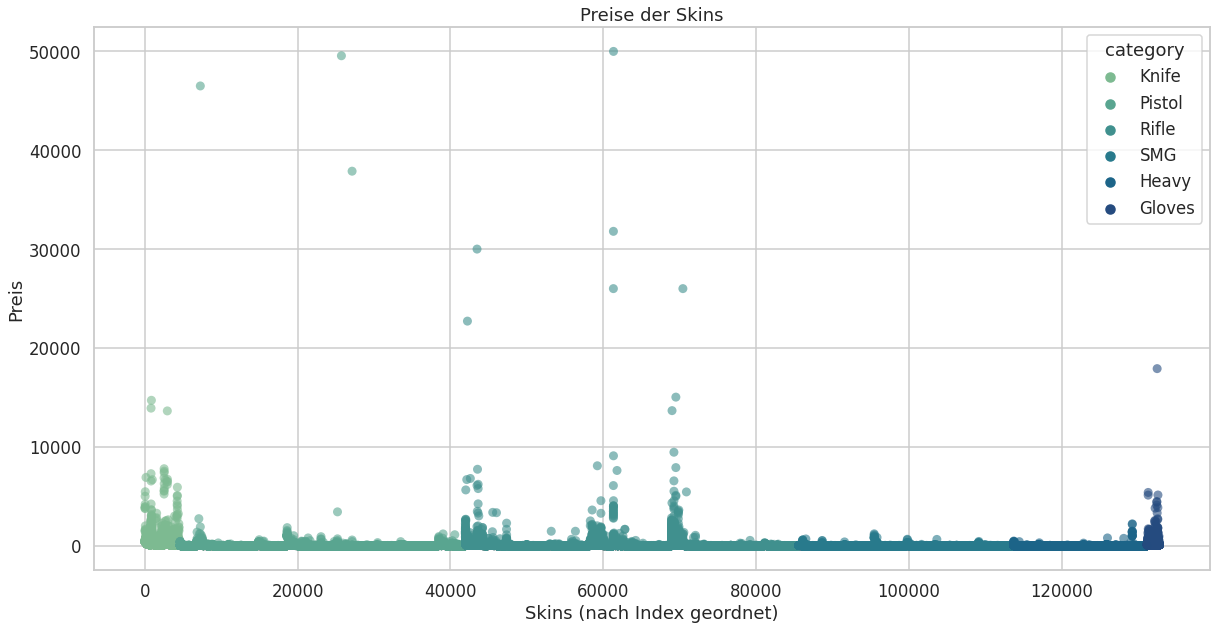

In [ ]:
sns.scatterplot(x=data.index, y=data.salePrice, hue=data.category, edgecolor = 'none', alpha = .6);
plt.xlabel("Skins (nach Index geordnet)")
plt.ylabel("Preis")
plt.title("Preise der Skins")
#sns.despine()

Hier sind bei über einem salePrice-Wert von über 10.000€ einige Ausreißer zu sehen. Diese werden nun genauer angesehen:

In [ ]:
data_ue10k = data[data['salePrice'] >= 10000]

In [ ]:
data_ue10k

,index,assetId,family,color,lock,version,versionType,suggestedPrice,salePrice,category,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
800,822,41787087,Doppler,#8650AC,0,Sapphire,phase,13461.54,13906.90,Knife,...,Factory New,★,Covert,#eb4b4b,The Breakout Collection,0,0,0,26.052475,moderately colorful
846,868,57386498,Gamma Doppler,#8650AC,0,Emerald,phase,14697.21,14700.87,Knife,...,Factory New,★,Covert,#eb4b4b,The Breakout Collection,0,0,0,16.608317,moderately colorful
2932,2998,47663996,Doppler,#8650AC,1,Sapphire,phase,9940.10,13627.13,Knife,...,Factory New,★,Covert,#eb4b4b,No Collection,0,0,0,46.872878,quite colorful
7253,7421,42288854,Cobalt Disruption,#D2D2D2,0,default,default,61.49,46505.17,Pistol,...,Factory New,Normal,Classified,#d32ee6,The eSports 2013 Winter Collection,1,0,0,43.392093,averagely colorful
25724,25895,45506601,Valence,#D2D2D2,0,default,default,0.60,49560.28,Pistol,...,Factory New,Normal,Mil-Spec Grade,#4b69ff,The Chroma 2 Collection,1,0,0,48.083679,quite colorful
27121,27292,43907576,Sand Dune,#FFD700,0,default,default,0.39,37880.51,Pistol,...,Well-Worn,Souvenir,Consumer Grade,#b0c3d9,The Dust 2 Collection,1,1,0,28.512152,moderately colorful
42223,42395,36210877,Redline,#CF6A32,0,default,default,154.38,22711.88,Rifle,...,Minimal Wear,StatTrak™,Classified,#d32ee6,The Phoenix Collection,1,0,1,10.358685,slightly colorful
43479,43651,49905872,Case Hardened,#CF6A32,0,Tier 2,pattern,265.04,30000.00,Rifle,...,Minimal Wear,StatTrak™,Classified,#d32ee6,The Arms Deal Collection,1,0,1,20.445109,moderately colorful
61329,61501,33573999,Howl,#CF6A32,0,default,default,16609.35,26000.00,Rifle,...,Factory New,StatTrak™,Covert,#eb4b4b,No Collection,1,0,1,24.433518,moderately colorful
61332,61504,26587537,Howl,#CF6A32,0,default,default,16609.35,31795.72,Rifle,...,Factory New,StatTrak™,Covert,#eb4b4b,No Collection,1,0,1,25.731520,moderately colorful


Hierbei handelt es sich um genau 15 Beobachtungen, welche im salePrice einen Wert größer 10.000€ haben. Groß auffällig sind dabei Index 25724, 7253, 27121, 42223, 43479, 61342, 69007, 70428 und 132516. Bei diesen 9 Beobachtungen ist das Delta zwischen salePrice und suggestedPrice ziemlich groß. Da der suggestedPrice auf einer Schätzung des Skins seitens Skinport basiert, besteht die Möglichkeit, dass der salePrice angemessen ist. 

Für einen besseren Eindruck, wird sich Beobachtung 25724 genauer angeguckt:

In [ ]:
data.iloc[25724]

index                                  25895
assetId                             45506601
family                               Valence
color                                #D2D2D2
lock                                       0
version                              default
versionType                          default
suggestedPrice                           0.6
salePrice                           49560.28
category                              Pistol
subCategory                             P250
pattern                                  655
finish                                   426
wear                                0.033475
type                   Mil-Spec Grade Pistol
exterior                         Factory New
quality                               Normal
rarity                        Mil-Spec Grade
rarityColor                          #4b69ff
collection           The Chroma 2 Collection
stickers                                   1
souvenir                                   0
stattrak  

Hier ein Bild dieses Skins:

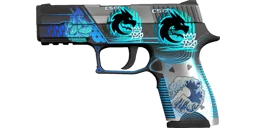

In [ ]:
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/45506601/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

Mittelwert und Median:

In [ ]:
valence = data[data['family'] == 'Valence']
valence[valence['category']=='Pistol'].salePrice.mean()

210.35270042194077

In [ ]:
valence[valence['category']=='Pistol'].salePrice.median()

0.1

Diese Waffe ist Factory New, hat entsprechend einen *wear* von 0.033, ist farbig (aber vor allem durch die Aufkleber). Allerdings ist es eher nicht üblich für eine Pistole in der *family 'Valence'* einen so hohen Preis zu verlangen (vergleiche Mittelwert und Median). Also ist dieses Item entweder ein Sammlerstück oder der Preis ist fälschlicherweise so hoch.

Im Folgenden einen Blick auf die Varianz von *suggestedPrice* und *salePrice* auf Basis des kompletten Datensatzes:

In [ ]:
# Varianz von suggestedPrice
round(data.suggestedPrice.var(),2)

40939.66

In [ ]:
# Varianz von salePrice
round(data.salePrice.var(),2)

139111.48

Es gibt deutliche Abweichungen. Allerdings kann vom suggestedPrice, welcher eine Annahme von Skinport ist, nicht auf die Besonderheit einer Skin gefolgert werden (wenn es sich beispielsweise um das Skin mit dem besten oder schlechtesten *wear* handelt - Sammlerstücke).

Entsprechend wurde sich dazu entschieden, die Preisvorhersagen auf salePrice zu machen, allerdings die Ausreißer über 10.000€ zu entfernen, um keine zu hohen Strafterme im späteren Modell zu erhalten.

In [ ]:
data = data[data['salePrice']<= 10000]

Nun sehen die Preise der Skins, auch bezogen auf die Kategorie, wie folgt aus:

Text(0.5, 1.0, 'Preise der Skins')

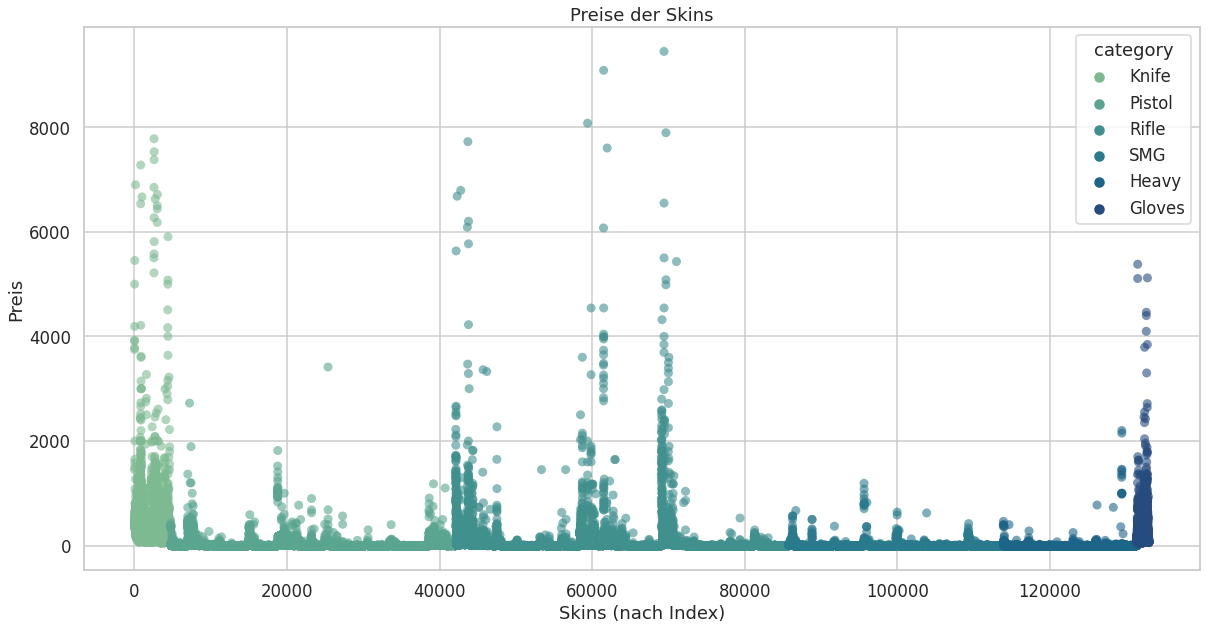

In [ ]:
sns.scatterplot(data = data, x='index', y='salePrice', hue='category', edgecolor = 'none', alpha = .6, palette = 'crest'); #Blues_d
plt.xlabel("Skins (nach Index)")
plt.ylabel("Preis")
plt.title("Preise der Skins")

###Features
Nun werden die übriggebliebenen Features weiter untersucht.

In [ ]:
# Unterteilung des Datensatzes in unterschiedliche Kategorien, um bessere (und vor allem granularere) Visualisierungen zu erstellen
data_knives = data[data['category']=='Knife']
data_gloves = data[data['category'] == 'Gloves']
data_pistols = data[data['category'] == 'Pistol']
data_smgs = data[data['category'] == 'SMG']
data_rifles = data[data['category'] == 'Rifle']
data_heavy = data[data['category'] == 'Heavy']

####**index, assetId**

Diese beiden Features tragen nichts zur Vorhersage zum Preis der Skins bei, da diese für jedes Feature unterschiedlich sind. Allerdings werden diese Features bis zur Aufstellung des Modells beibehalten, da sich über *index* Veranschaulichungen aufstellen lassen und über *assetId* die Bilder der Skins gezogen werden.

####**family**

Hierbei handelt es sich um die Unterunterkategorie der Skins. Die Hierarchie der Granularität ist wie folgt: category -> subCategory -> family.

In [ ]:
len(data.family.unique())

911

In [ ]:
# Test auf Duplikate um sicher zu stellen, dass sich nicht Unterunterkategorien mit demselben Namen in einer Unterkategorie befinden
data_fam = data.family.drop_duplicates()

In [ ]:
len(data_fam.unique())
# -> keine Duplikate

911

Entsprechend ist dies die Kategorie auf feinster Ebene, welche somit am meisten Informationen über die jeweiligen Skins bereithält. Somit sind die Features *category* und *subCategory* für das Modell nebensächlich. 

####**color** 

In [ ]:
data.groupby(['color', 'category'])['salePrice'].median()

color    category
#8650AC  Gloves      161.83
         Knife       235.00
#CF6A32  Heavy         0.46
         Pistol        2.21
         Rifle         6.51
         SMG           0.63
#D2D2D2  Heavy         0.04
         Pistol        0.13
         Rifle         0.17
         SMG           0.03
#FFD700  Heavy         0.03
         Pistol        0.04
         Rifle         0.03
         SMG           0.03
Name: salePrice, dtype: float64

Color hat 4 Ausprägungen. Zu sehen ist, dass *color #8650AC* nur für Gloves und Knives vertreten ist. Die restlichen 3 Ausprägungen von *color* erstrecken sich über die restlichen Kategorien. Entsprechend ist dieses Feature für weitere Analysen auszuschließen, da dieses Feature eher keinen Erklärungsgehalt bereitstellt. Sollte es sich bei diesem Feature um die Rarity-Colors handeln (Annahme), wäre dieses Feature zudem redundant (und hätte eine Rarity-Color zu wenig).

In [ ]:
data = data.drop('color', axis = 1)

####**lock**
Folgende Aggregation zeigt, dass Skins, die direkt verfügbar sind (lock = 0), im Median teurer sind als Skins, auf die gewartet werden muss nach Kauf (lock = 1). Diese Aggregation basiert auf der Kategorie *Knive*, um einen besseren Überblick zu erhalten:

In [ ]:
data_knives.groupby(['subCategory','lock'])['salePrice'].mean()

subCategory      lock
Bayonet          0        545.401667
                 1        428.041802
Bowie Knife      0        299.666071
                 1        212.931618
Butterfly Knife  0       1117.559375
                 1        943.617957
Classic Knife    0        276.824000
                 1        165.887049
Falchion Knife   0        238.465899
                 1        154.685755
Flip Knife       0        340.768254
                 1        250.719507
Gut Knife        0        145.685427
                 1        117.947564
Huntsman Knife   0        311.124147
                 1        215.938696
Karambit         0        988.807045
                 1        653.915594
M9 Bayonet       0        721.263226
                 1        453.548294
Navaja Knife     0        130.717460
                 1         95.951196
Nomad Knife      0        472.110000
                 1        378.271316
Paracord Knife   0        310.655000
                 1        168.139538
Shadow Daggers  

In [ ]:
temp = data_knives.groupby(["subCategory", "lock"]).mean().reset_index()
temp = temp[['subCategory', 'lock', 'salePrice']]

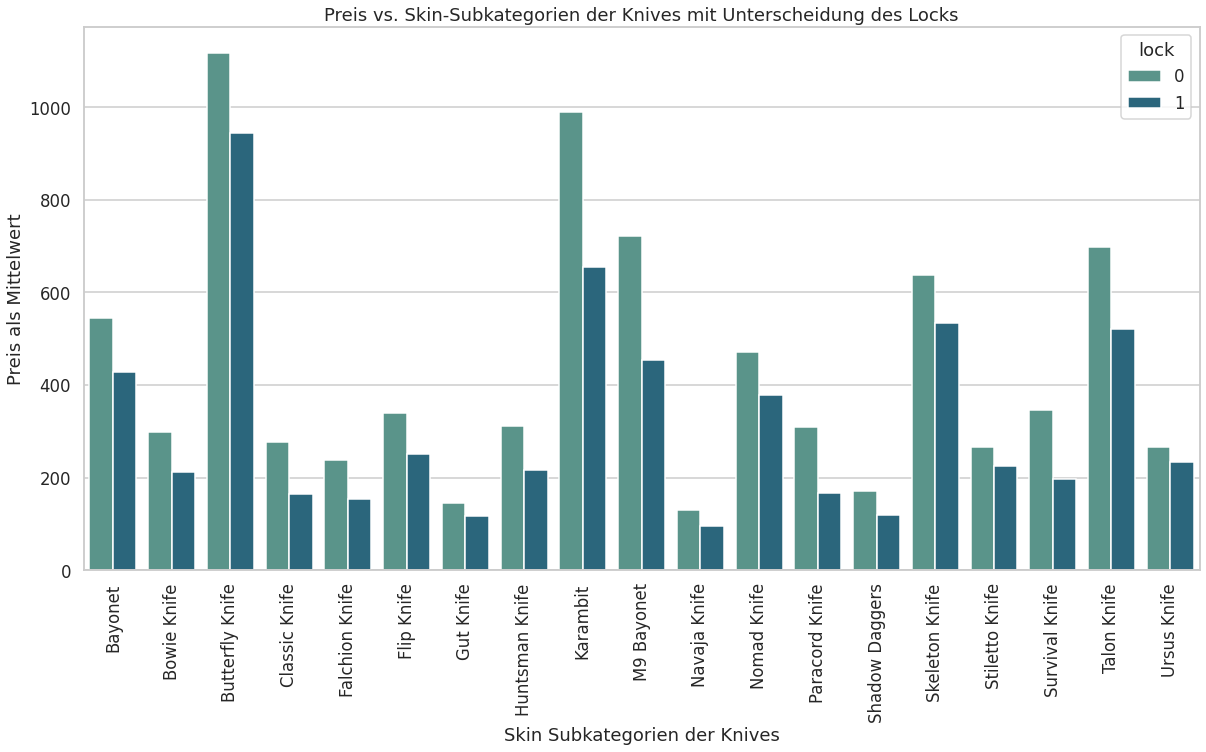

In [ ]:
sns.barplot(data = temp, x='subCategory', y='salePrice', hue='lock', palette = 'crest'); #Blues_d
plt.xlabel("Skin Subkategorien der Knives")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. Skin-Subkategorien der Knives mit Unterscheidung des Locks")
plt.tick_params(axis='x', rotation=90)

####**version**

Folgendes Grouping zeigt, dass nur die Skin-Kategorien *Knife, Pistol und Rifle* Ausprägungen der *versions* haben. 

In [ ]:
data.groupby(['category','version'])['salePrice'].mean()

category  version    
Gloves    default         310.887998
Heavy     default           2.343877
Knife     2nd Max         613.225000
          3rd Max         155.000000
          4th Max         159.870000
          5th Max         164.750000
          6th Max         145.000000
          7th Max         138.000000
          Black Pearl    1038.988529
          Emerald        1753.923200
          FFI            1066.408571
          Max Fake       2089.490000
          Phase 1         336.911984
          Phase 2         502.805043
          Phase 3         351.671901
          Phase 4         420.120629
          Rank 4          787.425000
          Ruby           2126.546333
          Sapphire       1918.834154
          default         310.150380
Pistol    Emerald         193.331608
          Phase 1          18.988121
          Phase 2          22.211054
          Phase 3          19.012727
          Phase 4          20.797513
          Tier 1          171.873000
          Tier 2

Da *Knife* am meisten Ausprägungen enthält, basiert auch hier die Visualisierung auf der Kategorie *Knife*.

In [ ]:
temp = data_knives.groupby("version").mean().reset_index()
#temp = temp[['subCategory', 'lock', 'salePrice']]
temp = temp[['version','salePrice']]
temp = temp.sort_values(by='salePrice', ascending=False)

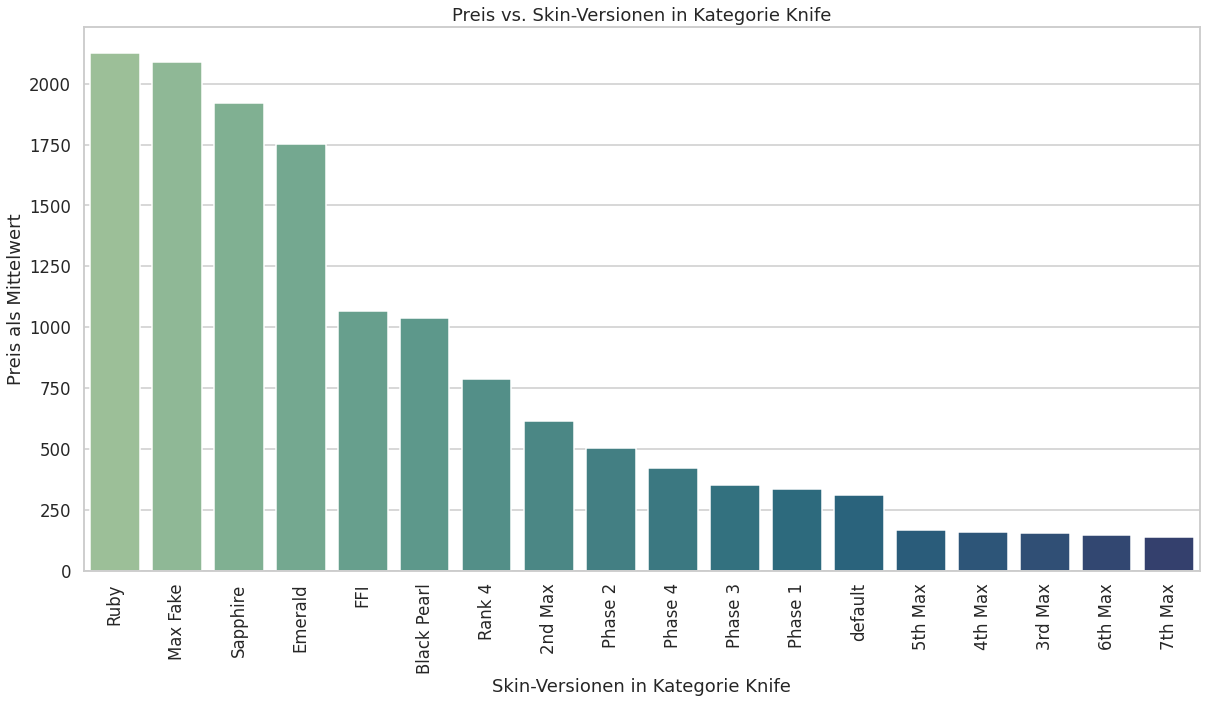

In [ ]:
sns.barplot(data = temp, x='version', y='salePrice', palette = 'crest'); #Blues_d
plt.xlabel("Skin-Versionen in Kategorie Knife")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. Skin-Versionen in Kategorie Knife")
plt.tick_params(axis='x', rotation=90)

####**versionType**

In [ ]:
data.groupby(['versionType', 'version'])['salePrice'].mean()

versionType  version    
default      default          25.127565
pattern      2nd Max         613.225000
             3rd Max         155.000000
             4th Max         159.870000
             5th Max         164.750000
             6th Max         145.000000
             7th Max         138.000000
             FFI            1066.408571
             Max Fake       2089.490000
             Rank 4          787.425000
             Tier 1         1068.847500
             Tier 2          160.425301
phase        Black Pearl    1038.988529
             Emerald         425.562500
             Phase 1         212.605261
             Phase 2         267.122319
             Phase 3         222.304444
             Phase 4         259.224259
             Ruby           2126.546333
             Sapphire       1918.834154
Name: salePrice, dtype: float64

In [ ]:
data.groupby(['versionType'])['salePrice'].mean()

versionType
default     25.127565
pattern    363.042520
phase      365.884103
Name: salePrice, dtype: float64

In [ ]:
data.groupby(['versionType']).size()

versionType
default    130383
pattern       123
phase        2301
dtype: int64

*versionType* kann als Überkategorie von *version* gesehen werden. Da die *version* entsprechend genauer ist als *versionType*, kann *versionType* zukünftig vernachlässigt werden und wird somit aus dem Datensatz entfernt.

In [ ]:
data = data.drop(['versionType'], axis=1)

####**suggestedPrice**

Wie bereits erwähnt beruht *suggestedPrice* auf einer Annahme der Skinpreise von Skinport. Für das Modell wird dieser nicht benötigt, da sich auf *salePrice* fokussiert wird. Das Feature wird aber erhalten, um einen Vergleich zum erstellten Modell zu ziehen.

####**category**

In [ ]:
order = data.groupby(['category'])['salePrice'].mean().sort_values(ascending=False)

Text(0.5, 1.0, 'Logarithmierter Preis vs. Skin-Kategorien')

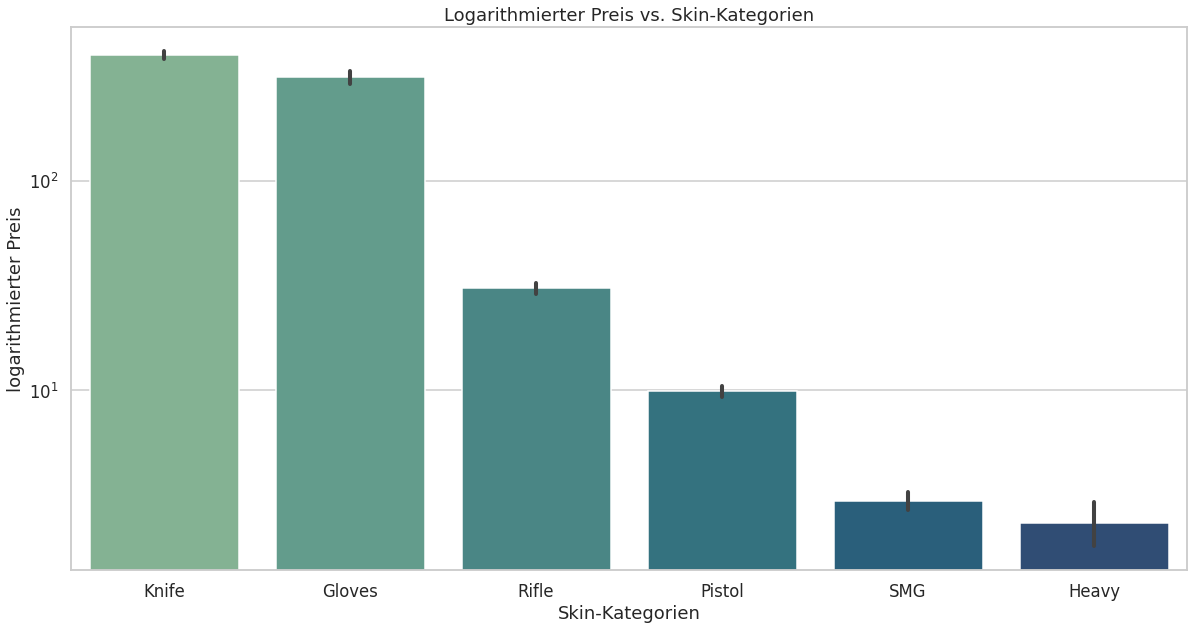

In [ ]:
g = sns.barplot(x='category', y='salePrice', data=data, order = order.index)
g.set_yscale("log")
plt.xlabel("Skin-Kategorien")
plt.ylabel("logarithmierter Preis")
plt.title("Logarithmierter Preis vs. Skin-Kategorien")

####**subCategory**

Hier nun eine Visualisierung, welche zeigt, wie unterschiedlich die Preise in den verschiedenen *subCategories* sind. Um eine überschaubarere Grafik zu erhalten, wurde der *salePrice* auf > 50 gesetzt. Somit bleiben die Kategorien *Gloves, Knife, Rifle* übrig:

In [ ]:
temp = data.groupby(["category", "subCategory"]).mean().reset_index()
temp = temp[['category', 'subCategory', 'salePrice']]
temp = temp[temp['salePrice'] > 50]

In [ ]:
temp = temp.sort_values(by=['category', 'salePrice'], ascending=False)

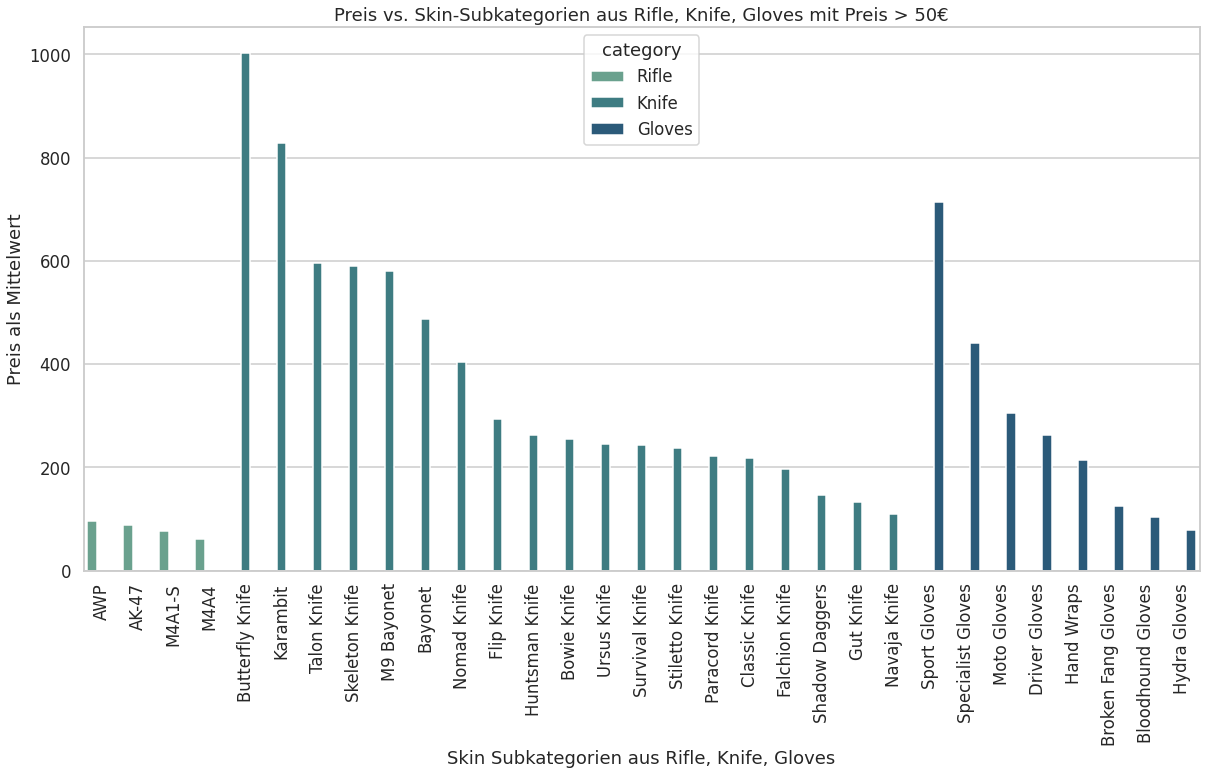

In [ ]:
sns.barplot(data = temp, x='subCategory', y='salePrice', hue='category', palette = 'crest'); #Blues_d
plt.xlabel("Skin Subkategorien aus Rifle, Knife, Gloves")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. Skin-Subkategorien aus Rifle, Knife, Gloves mit Preis > 50€")
plt.tick_params(axis='x', rotation=90)

####Speicherpunkt 2:

In [ ]:
# Speicherpunkt 2: Zwischenspeichern der Daten, sodass Prozess nicht immer wieder durchlaufen werden muss
data.to_csv(r'allitems_cleaned_2.csv', index=False, header=True)

In [ ]:
# Ladepunkt 2: Laden der Daten, sodass hier eingestiegen werden kann
data = pd.read_csv(r'/content/drive/MyDrive/SA_BA/Data/allitems_cleaned_2.csv')

####**pattern**

In [ ]:
len(data.pattern.unique())

1001

Im Datensatz befinden sich 1001 unterschiedliche Ausprägungen des Features *pattern*.

Text(0.5, 1.0, 'Preis vs. Pattern')

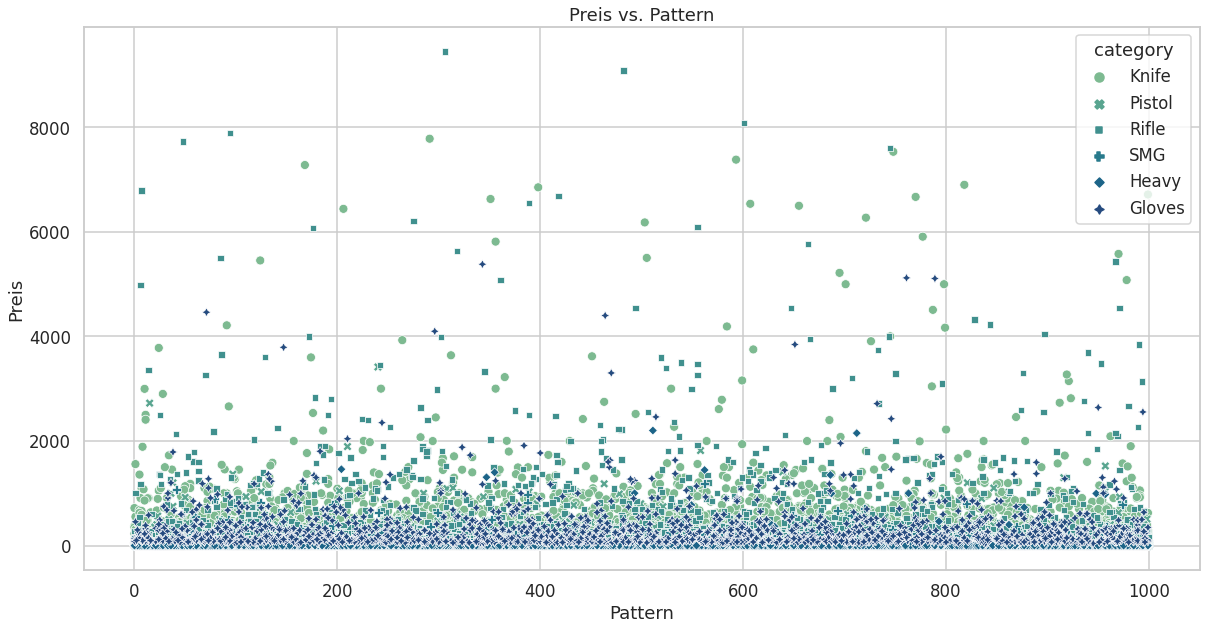

In [ ]:
sns.scatterplot(data = data, x='pattern', y='salePrice', hue = 'category', style = 'category')
plt.xlabel("Pattern")
plt.ylabel("Preis")
plt.title("Preis vs. Pattern")

Hier ist der Visualisierung auf den ersten Blick keine Besonderheit zu entnehmen. Es gibt kein *pattern*, welches eine Besonderheit hat. Zu jedem Pattern gibt es unterschiedlich preisige Skins. *pattern* sollte eher als ein kategorisches Feature gesehen werden, da ein Pattern von 1000 nicht besser ist als ein Pattern von 0. Hier besteht kein linearer Zusammenhang. 

####**finish**

Jeder CS:GO-Skin hat einen Finish-Katalog, der in den Spieldateien definiert ist. Diese Nummer ist nützlich, um die Phase eines Doppler- oder Gamma-Doppler-Messers zu identifizieren, ist aber für die meisten anderen Skins nicht relevant. Entsprechend wird dieses Feature entfernt.

Folgende Plots sollen zeigen, dass Skins auch in unterschiedlichen Intervallen des Finish-Features eingeordnet sind. Dies bekräftigt die Entscheidung, dieses Feature zu löschen.



Text(0.5, 1.0, 'Preis vs. Finish in Kategorie Gloves')

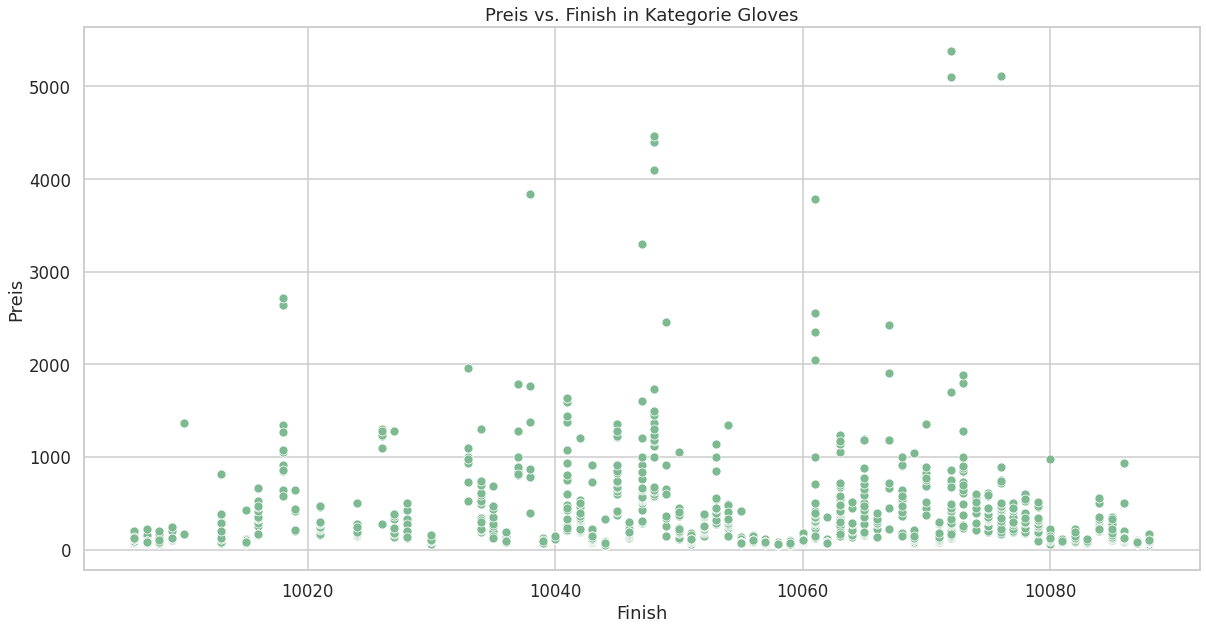

In [ ]:
# Zeige Finish-Range der Gloves
sns.scatterplot(data = data_gloves, x='finish', y='salePrice')
plt.xlabel("Finish")
plt.ylabel("Preis")
plt.title("Preis vs. Finish in Kategorie Gloves")

Text(0.5, 1.0, 'Preis vs. Finish in Kategorie Knife')

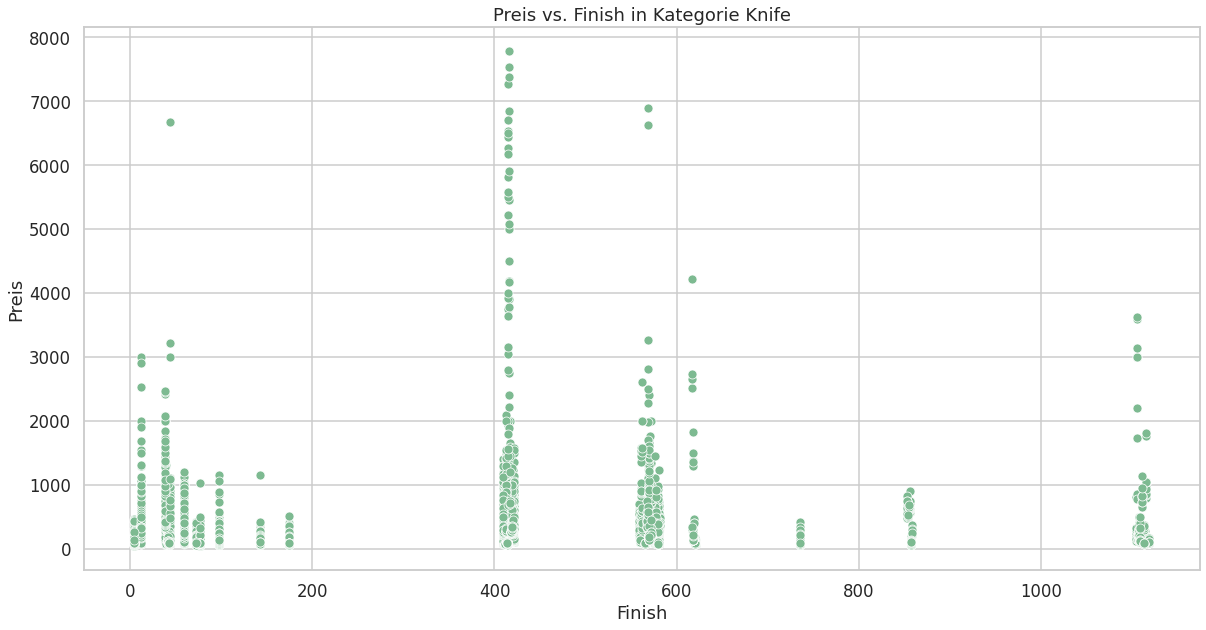

In [ ]:
# Zeige Finish-Range der Knives
sns.scatterplot(data = data_knives, x='finish', y='salePrice')
plt.xlabel("Finish")
plt.ylabel("Preis")
plt.title("Preis vs. Finish in Kategorie Knife")

Text(0.5, 1.0, 'Preis vs. Pattern')

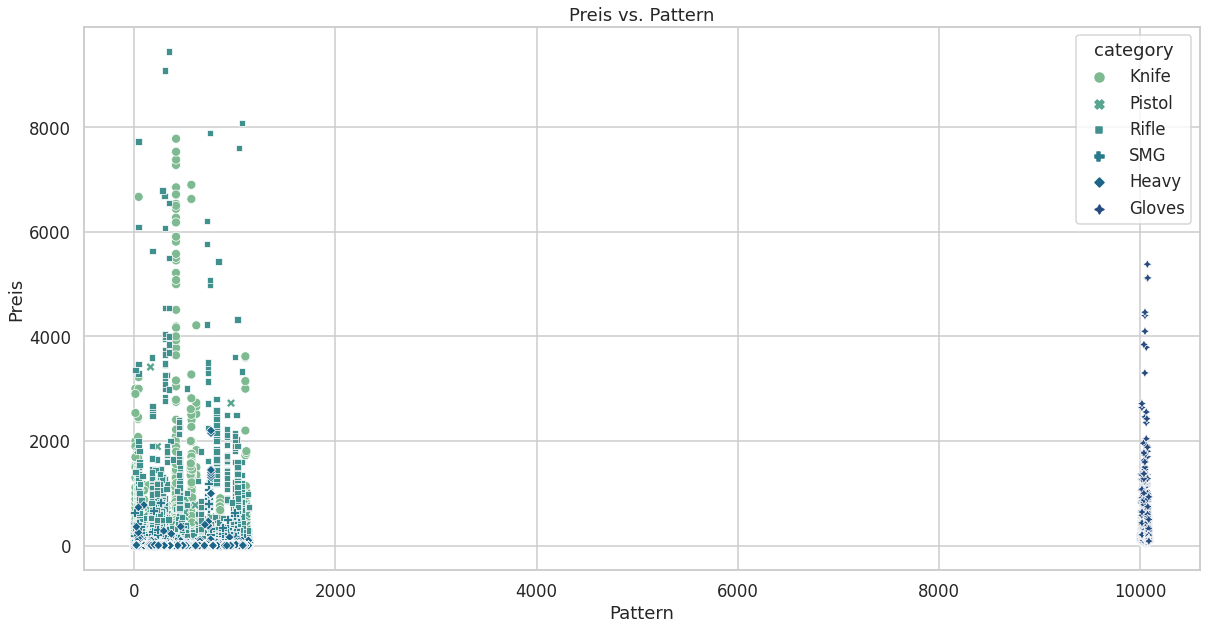

In [ ]:
# Finish-Range von allen Skins
sns.scatterplot(data = data, x='finish', y='salePrice', hue = 'category', style = 'category')
plt.xlabel("Pattern")
plt.ylabel("Preis")
plt.title("Preis vs. Pattern")

In [ ]:
data = data.drop('finish', axis = 1)

####**wear**

In [ ]:
ot = data_gloves[data_gloves['family']=='Overtake']

In [ ]:
data[data['category']=='Gloves'].family.unique()

array(['Charred', 'Snakebite', 'Bronzed', 'Guerrilla', 'Imperial Plaid',
       'Snow Leopard', 'Black Tie', 'Overtake', 'King Snake',
       'Crimson Weave', 'Lunar Weave', 'Rezan the Red', 'Queen Jaguar',
       'Racing Green', 'Convoy', 'Diamondback', 'Cobalt Skulls',
       'Overprint', 'CAUTION!', 'Slaughter', 'Duct Tape',
       'Desert Shamagh', 'Leather', 'Badlands', 'Constrictor', 'Giraffe',
       'Arboreal', 'Spruce DDPAT', 'Case Hardened', 'Emerald', 'Mangrove',
       'Rattler', 'Polygon', 'Blood Pressure', 'Turtle', 'Smoke Out',
       'Finish Line', 'Transport', 'POW!', 'Eclipse', 'Boom!',
       'Spearmint', '3rd Commando Company', 'Cool Mint', 'Crimson Web',
       'Fade', 'Emerald Web', 'Mogul', 'Crimson Kimono', 'Tiger Strike',
       'Marble Fade', 'Field Agent', 'Lt. Commander', 'Foundation',
       'Buckshot', 'Forest DDPAT', 'Vice', 'Scarlet Shamagh', 'Omega',
       'Amphibious', 'Slingshot', 'Superconductor', "Pandora's Box",
       'Hedge Maze', 'Nocts', 'Bron

Folgender Plot beruht auf den ganzen Daten. Es ist zu erkennen, dass die Preise höher sind, wenn der *wear* niedriger ist. Allerdings Zeigt die Regression eine nahezu gerade Linie an. Dies liegt Wahrscheinlich daran, dass sich die meisten Beobachtungen im unteren Preisraum.

Text(0.5, 1.0, "Preis vs. 'wear' aller Kategorien")

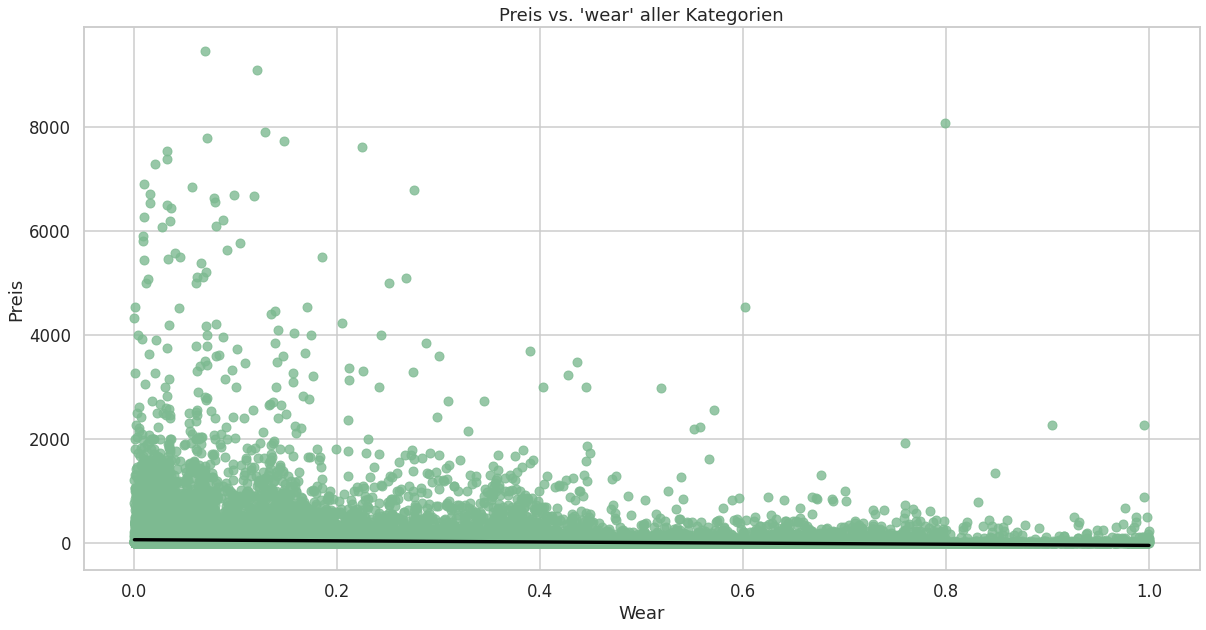

In [ ]:
sns.regplot(data = data, x='wear', y='salePrice', line_kws={"color": "black"})
plt.xlabel("Wear")
plt.ylabel("Preis")
plt.title("Preis vs. 'wear' aller Kategorien")

Um eine interessantere Regressionsgerade zu erlangen, wird sich nun auf die Kategorie *Knife* fokussiert.

Text(0.5, 1.0, "Preis vs. 'wear' der Kategorie Knife")

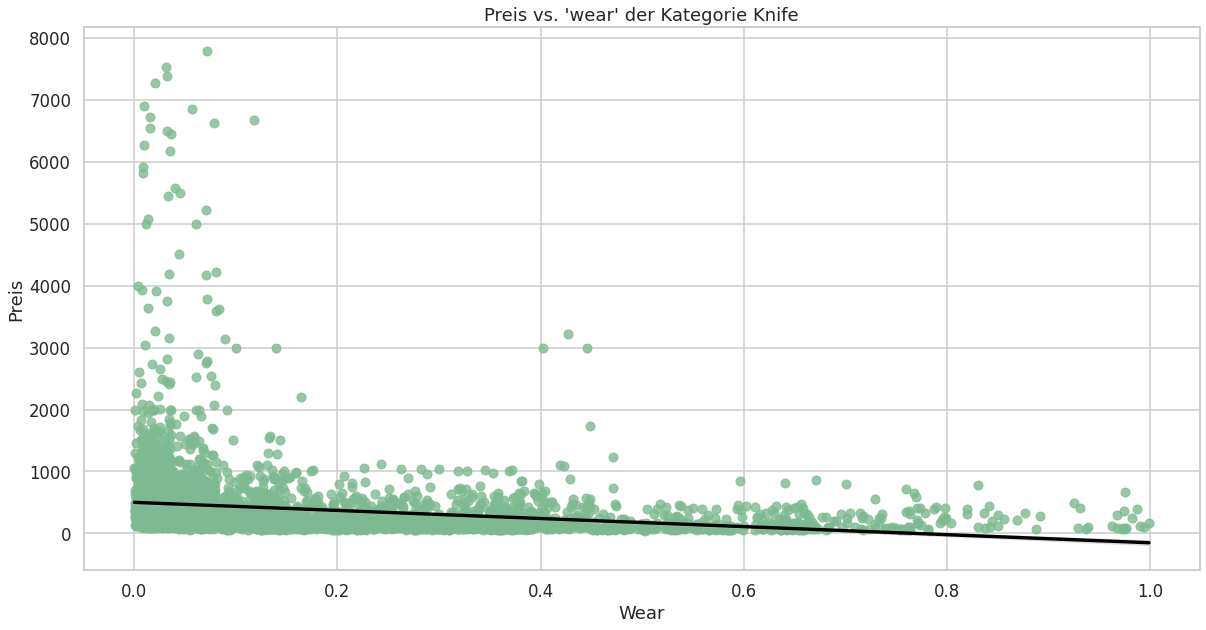

In [ ]:
sns.regplot(data = data_knives, x='wear', y='salePrice', line_kws={"color": "black"})
plt.xlabel("Wear")
plt.ylabel("Preis")
plt.title("Preis vs. 'wear' der Kategorie Knife")

Um weiter in die Tiefe zu gehen, wird sich nun auf die Unterkategorie *Bayonet* aus der Kategorie *Knife* fokussiert.

Text(0.5, 1.0, 'Preis vs. Wear der Subkategorie Bayonet')

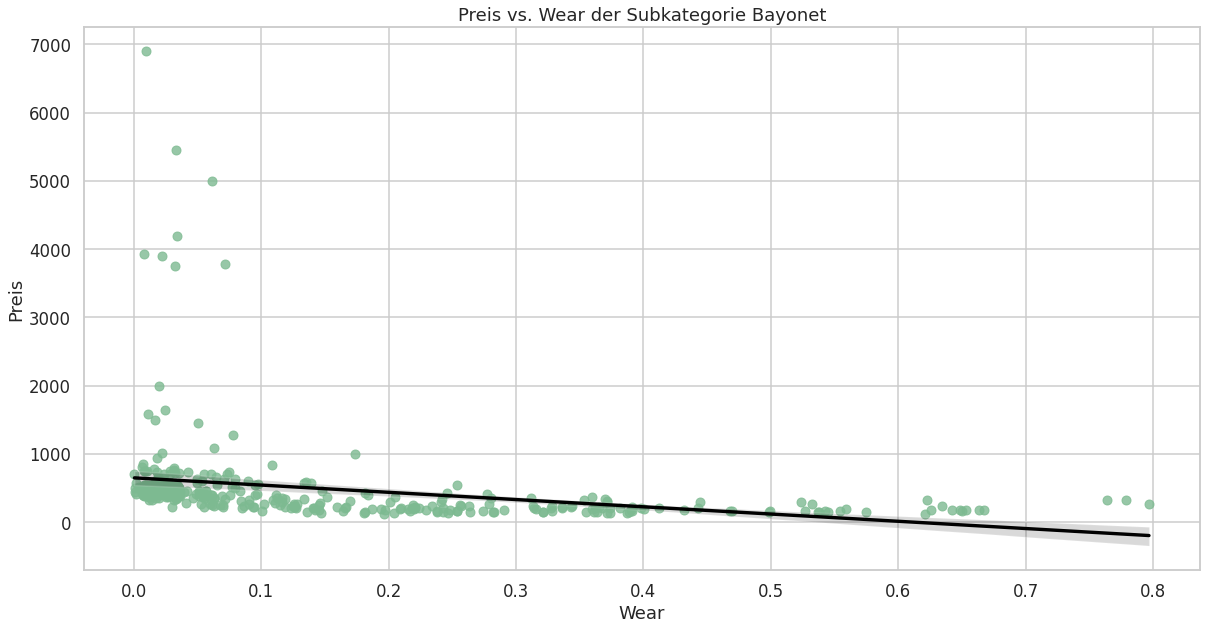

In [ ]:
bayonet = data_knives[data_knives['subCategory']=='Bayonet']
sns.regplot(data = bayonet, x='wear', y='salePrice', line_kws={"color": "black"})#, hue = 'category')
plt.xlabel("Wear")
plt.ylabel("Preis")
plt.title("Preis vs. Wear der Subkategorie Bayonet")

####**type**

Das Feature *type* kann gelöscht werden, da es sich um eine namentliche Zusammensetzung aus den Featuren *souvenir, stattrak, subCategory und rarity* handelt, die bereits im Datensatz granularer vorhanden sind. Siehe folgender Output:

In [ ]:
data.type.unique()

array(['★ Covert Knife', '★ StatTrak™ Covert Knife', 'Restricted Pistol',
       'Souvenir Restricted Pistol', 'Mil-Spec Grade Pistol',
       'Classified Pistol', 'StatTrak™ Classified Pistol',
       'StatTrak™ Restricted Pistol', 'StatTrak™ Covert Pistol',
       'Covert Pistol', 'StatTrak™ Mil-Spec Grade Pistol',
       'Industrial Grade Pistol', 'Souvenir Industrial Grade Pistol',
       'Consumer Grade Pistol', 'Souvenir Mil-Spec Grade Pistol',
       'Souvenir Consumer Grade Pistol', 'Souvenir Classified Pistol',
       'Covert Rifle', 'Souvenir Covert Rifle', 'StatTrak™ Covert Rifle',
       'Classified Rifle', 'StatTrak™ Classified Rifle',
       'Souvenir Classified Rifle', 'Restricted Rifle',
       'StatTrak™ Restricted Rifle', 'Mil-Spec Grade Rifle',
       'Souvenir Mil-Spec Grade Rifle', 'StatTrak™ Mil-Spec Grade Rifle',
       'Souvenir Restricted Rifle', 'Industrial Grade Rifle',
       'Souvenir Industrial Grade Rifle', 'Consumer Grade Rifle',
       'Souvenir Consume

In [ ]:
data = data.drop('type', axis=1)

####**exterior**

Hierbei handelt es sich um eine Kategorisierung des Features *wear*.

Text(0.5, 1.0, 'Preis vs. Qualitätsfeature der Skins')

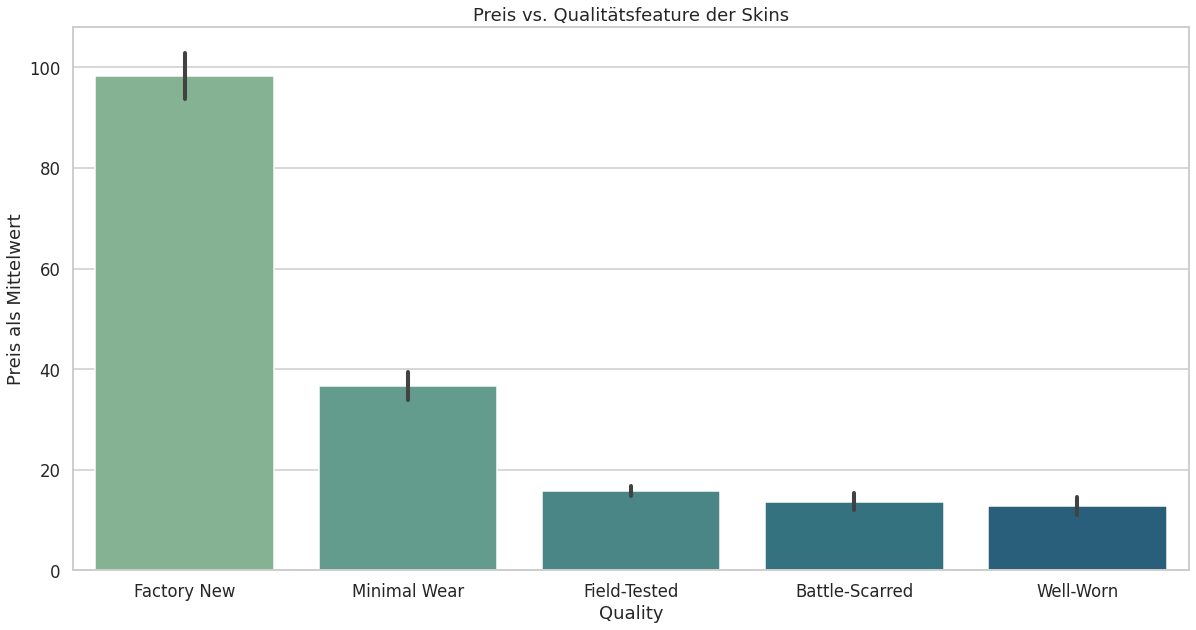

In [ ]:
sns.barplot(data = data, x='exterior', y='salePrice'); 
plt.xlabel("Quality")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. Qualitätsfeature der Skins")

####**quality**

Das Feature *quality* beinhaltet die Features *souvenir* und *stattrak*. Zudem beinhaltet *quality* auch unterschiedliche StatTrak-Ausführungen.

Zu beachten ist allerdings, dass nicht jeder Kategorie dieselben Ausprägung des Features *quality* besitzt. Heavy, SMG, Rifle und Pistol haben dieselbe Ausprägung. Knife und Gloves nicht, da diese als sogenannte "Special Rare Items" durchgehen und immer mit einem Stern gekennzeichnet sind.

In [ ]:
zw = data.groupby(['category', "quality"]).mean().reset_index()
zw = zw[['category', 'quality']]
zw

,category,quality
0,Gloves,★
1,Heavy,Normal
2,Heavy,Souvenir
3,Heavy,StatTrak™
4,Knife,★
5,Knife,★ StatTrak™
6,Pistol,Normal
7,Pistol,Souvenir
8,Pistol,StatTrak™
9,Rifle,Normal


In [ ]:
temp = data.groupby("quality").mean().reset_index()
temp = temp[['quality','salePrice']]
temp = temp.sort_values(by='salePrice', ascending=False)

Text(0.5, 1.0, 'Preis vs. Qualitätsfeature der Skins')

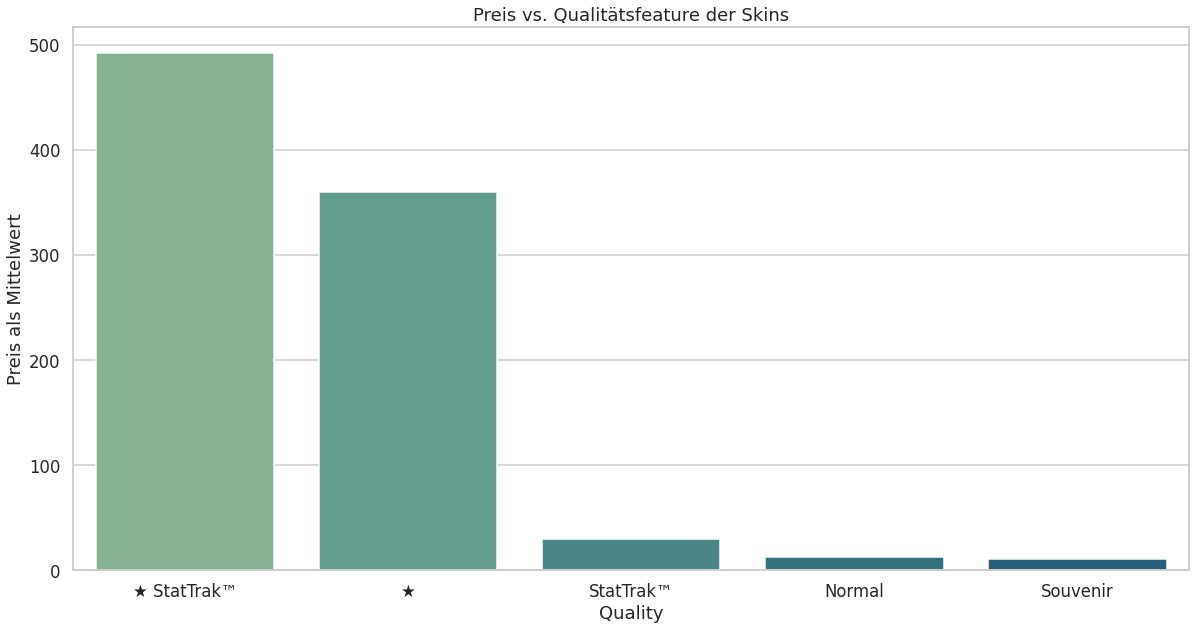

In [ ]:
sns.barplot(data = temp, x='quality', y='salePrice'); 
plt.xlabel("Quality")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. Qualitätsfeature der Skins")

####**rarity**

In [ ]:
temp = data.groupby("rarity").mean().reset_index()
temp = temp[['rarity','salePrice']]
temp = temp.sort_values(by='salePrice', ascending=False)

Text(0.5, 1.0, 'Logarithmierter Preis vs. Rarität der Skins')

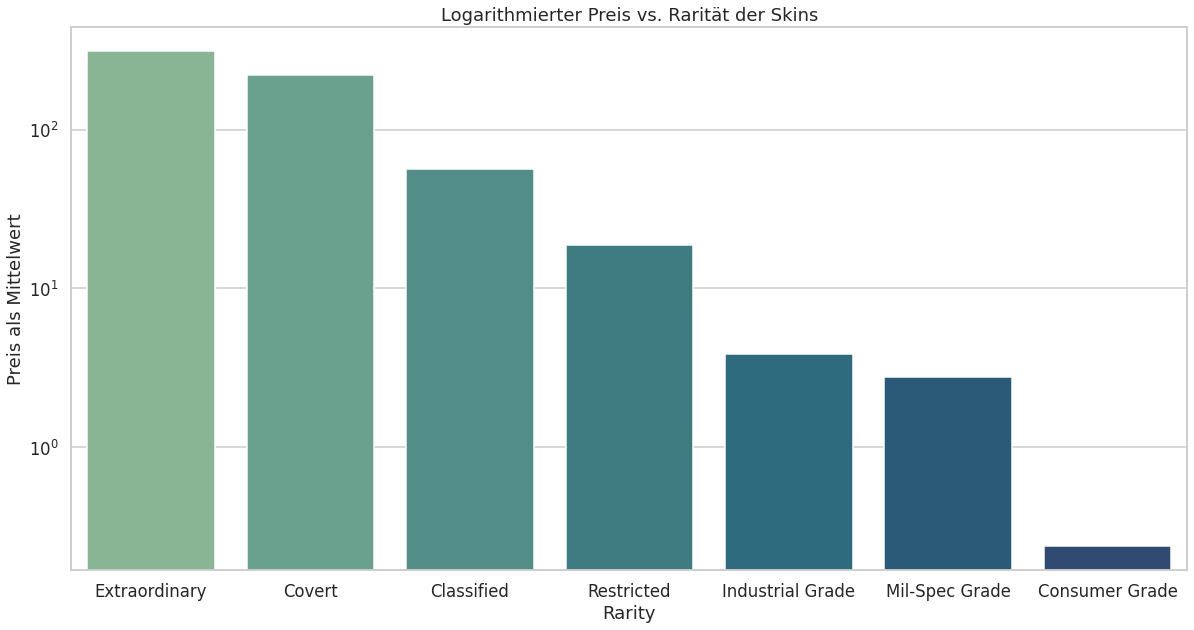

In [ ]:
g = sns.barplot(data = temp, x='rarity', y='salePrice', palette = 'crest'); 
plt.xlabel("Rarity")
g.set_yscale("log")
plt.ylabel("Preis als Mittelwert")
plt.title("Logarithmierter Preis vs. Rarität der Skins")

####**rarityColor**

Dieses Feature kann entfernt werden, da es sich hierbei um ein redundantes Feature zu *rarity* handelt. 

In [ ]:
data = data.drop('rarityColor', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


####**collection**

Das hier sind die hochpreisigsten Kollektionen, wenn alle Skins miteinbezogen werden:

In [ ]:
print(data.groupby(['collection'])['salePrice'].mean().sort_values(ascending=False).head(3))
print()
print("Anzahl Kollektionen: " + str(len(data.collection.unique())))

collection
The Assault Collection    653.222895
No Collection             394.880666
The Bravo Collection      346.157920
Name: salePrice, dtype: float64

Anzahl Kollektionen: 75


Im Folgenden werden sich gesondert nach den Kategorien die jeweils hochpreisigsten Kollektionan angesehen:

In [ ]:
# Für Pistolen
print(data_pistols.groupby(['category','collection'])['salePrice'].mean().sort_values(ascending=False).head(3))
print()
print("Anzahl Kollektionen: " + str(len(data_pistols.groupby(['category','collection'])['salePrice'].mean())))

category  collection                 
Pistol    The Assault Collection         876.238519
          The eSports 2013 Collection    382.316429
          The Dust Collection            292.202973
Name: salePrice, dtype: float64

Anzahl Kollektionen: 72


In [ ]:
# Für SMGs
print(data_smgs.groupby(['category','collection'])['salePrice'].mean().sort_values(ascending=False).head(3))
print()
print("Anzahl Kollektionen: " + str(len(data_smgs.groupby(['category','collection'])['salePrice'].mean())))

category  collection           
SMG       The Bravo Collection     113.083500
          The Norse Collection     103.200952
          The Canals Collection     86.153929
Name: salePrice, dtype: float64

Anzahl Kollektionen: 69


In [ ]:
# Für Rifles
print(data_rifles.groupby(['category','collection'])['salePrice'].mean().sort_values(ascending=False).head(3))
print()
print("Anzahl Kollektionen: " + str(len(data_rifles.groupby(['category','collection'])['salePrice'].mean())))

category  collection                
Rifle     No Collection                 4008.824706
          The Cobblestone Collection    2275.680370
          The Rising Sun Collection      574.783881
Name: salePrice, dtype: float64

Anzahl Kollektionen: 71


In [ ]:
# Für Heavy
print(data_heavy.groupby(['category','collection'])['salePrice'].mean().sort_values(ascending=False).head(3))
print()
print("Anzahl Kollektionen: " + str(len(data_heavy.groupby(['category','collection'])['salePrice'].mean())))

category  collection           
Heavy     The Norse Collection     365.077917
          The Canals Collection    210.661818
          The Dust Collection      134.508000
Name: salePrice, dtype: float64

Anzahl Kollektionen: 67


In [ ]:
# Für Knives
print(data_knives.groupby(['category','collection'])['salePrice'].mean().sort_values(ascending=False).head(3))
print()
print("Anzahl Kollektionen: " + str(len(data_knives.groupby(['category','collection'])['salePrice'].mean())))

category  collection             
Knife     The Breakout Collection    1002.832057
          No Collection               420.263980
          The Huntsman Collection     262.147293
Name: salePrice, dtype: float64

Anzahl Kollektionen: 6


In [ ]:
# Für Gloves
print(data_gloves.groupby(['category','collection'])['salePrice'].mean().sort_values(ascending=False).head(3))
print()
print("Anzahl Kollektionen: " + str(len(data_gloves.groupby(['category','collection'])['salePrice'].mean())))

category  collection   
Gloves    No Collection    310.887998
Name: salePrice, dtype: float64

Anzahl Kollektionen: 1


Folgende Tabelle gibt die Ergebnisse der Auswertungen wider:

Kategorie | Kollektion | Mittelwert (Preis)
--- | --- | ---
Gloves | No Collection | 310,89€
Knives | The Breakout Collection | 1002,83€
Knives | No Collection | 420,27€
Knives | The Huntsman Collection | 262,15€
Heavy| The Norse Collection | 365,08€
Heavy| The Canals Collection | 210,67€
Heavy| The Dust Collection | 134,51€
Rifle | No Collection | 4008,82€
Rifle | The Cobblestone Collection | 2275,68€
Rifle | The Rising Sun Collection | 574,78€
SMG | The Bravo Collection | 113,08€
SMG | The Norse Collection | 103,20€
SMG | The Canals Collection | 86,15€
Pistol | The Assault Collection | 876,24€
Pistol | The eSports 2013 Collection | 382,32€
Pistol | The Dust Collection | 292,20€


Hierbei ist zu beachten, dass Skins der Kategorie *Gloves* keiner Kollektion zugeordnet sind. *Knives* sind zugeordnet, finden allerdings ihre Ausprägung nur in 6 von insgesamt 75 Kollektionen wieder. In den Kategorien *Heavy, Rifle, SMG* und *Pistol* sind zwischen 67 und 72 Kollektionen ausgeprägt.

Hiermit kann also nicht gesagt werden, dass es eine besondere Kollektion gibt, die über alle Skin-Kategorien am teuersten ist. Es kann lediglich gesagt werden, dass die Kollektion *The Norse Collection* bei den Kategorien *Heavy* und *SMG* besonders teuer sind, die Kollektion *The Dust Collection* bei den Kategorien *Heavy* und *Pistol* und die Kollektion *The Canals Collection* bei den Kategorien *Heavy* und *SMG*

Folgende Visualisierung zeigt die über alle Skin-Kategorien gesehen top 5 Kollektionen:

In [ ]:
best_5_collections = data.groupby(['collection'])['salePrice'].mean().sort_values(ascending=False).head(5)
best_5_collections = best_5_collections.index.tolist()
b5 = data[data['collection'].isin(best_5_collections)]

In [ ]:
order = b5.groupby(['collection'])['salePrice'].mean().sort_values(ascending=False).index.tolist()

['The Assault Collection',
 'No Collection',
 'The Bravo Collection',
 'The Arms Deal Collection',
 'The Cobblestone Collection']

Text(0.5, 1.0, 'Logarithmierter Preis vs. top 5 Kollektionen der Skins, aufgeteilt in Kategorien')

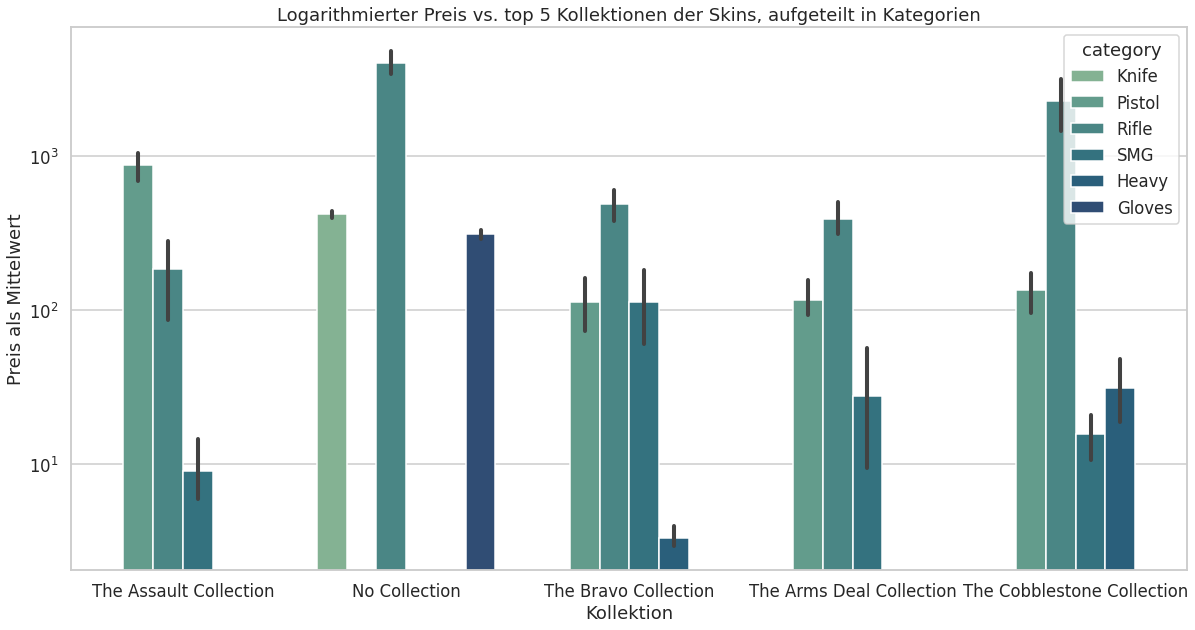

In [ ]:
g = sns.barplot(data = b5, x='collection', y='salePrice', hue = 'category', palette = 'crest', order = order); 
plt.xlabel("Kollektion")
g.set_yscale("log")
plt.ylabel("Preis als Mittelwert")
plt.title("Logarithmierter Preis vs. top 5 Kollektionen der Skins, aufgeteilt in Kategorien")

Text(0.5, 1.0, 'Preis vs. top 5 Kollektionen der Skins')

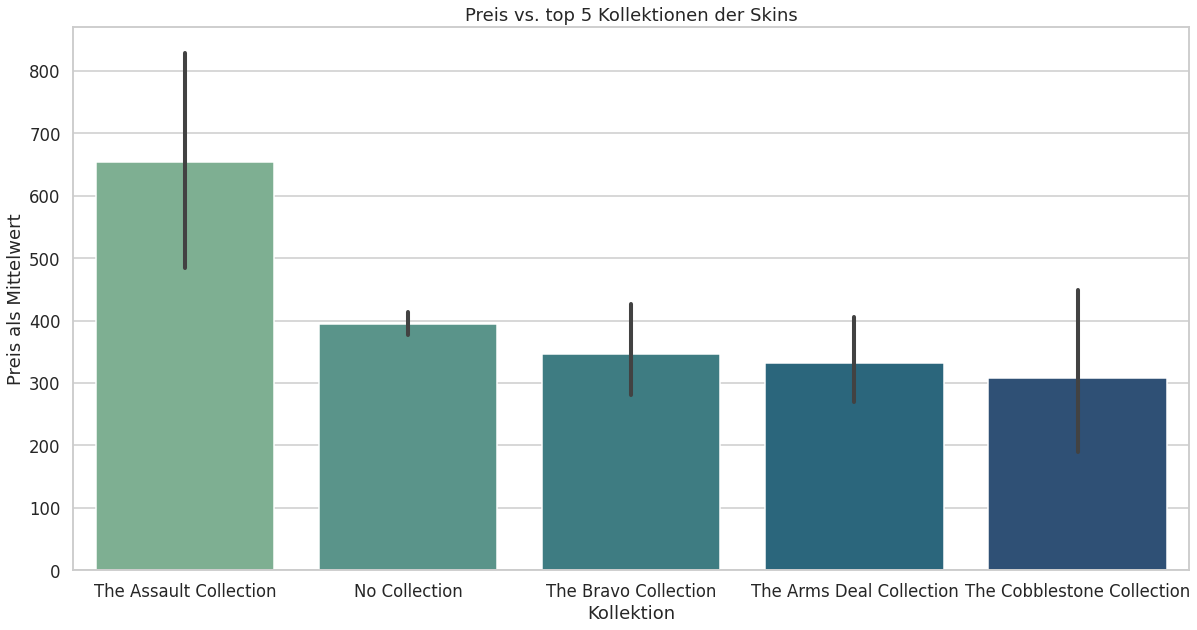

In [ ]:
g = sns.barplot(data = b5, x='collection', y='salePrice', palette = 'crest', order = order); 
plt.xlabel("Kollektion")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. top 5 Kollektionen der Skins")

####**stickers**

Die Kategorien *Knive* und *Gloves* können keine Sicker besitzen. Hierfür übrig bleiben die Kategorien *Heavy, SMG*, *Rifle* und *Pistol*. Untersucht wird das Feature *stickers* mit der Kategorie *Pistol*.

In [ ]:
data_pistols.groupby(['subCategory','stickers'])['salePrice'].mean()

subCategory    stickers
CZ75-Auto      0            3.512063
               1            8.485730
Desert Eagle   0           26.062255
               1           34.732154
Dual Berettas  0            0.693772
               1            5.232417
Five-SeveN     0            3.952713
               1           25.232159
Glock-18       0           18.535821
               1           36.064062
P2000          0            2.006472
               1           23.075544
P250           0            1.660483
               1           11.649308
R8 Revolver    0            0.682501
               1            1.312387
Tec-9          0            0.755211
               1            9.153262
USP-S          0           19.950423
               1           23.889670
Name: salePrice, dtype: float64

In [ ]:
temp = data_pistols.groupby(["subCategory", "stickers"]).mean().reset_index()
temp = temp[['subCategory', 'stickers', 'salePrice']]

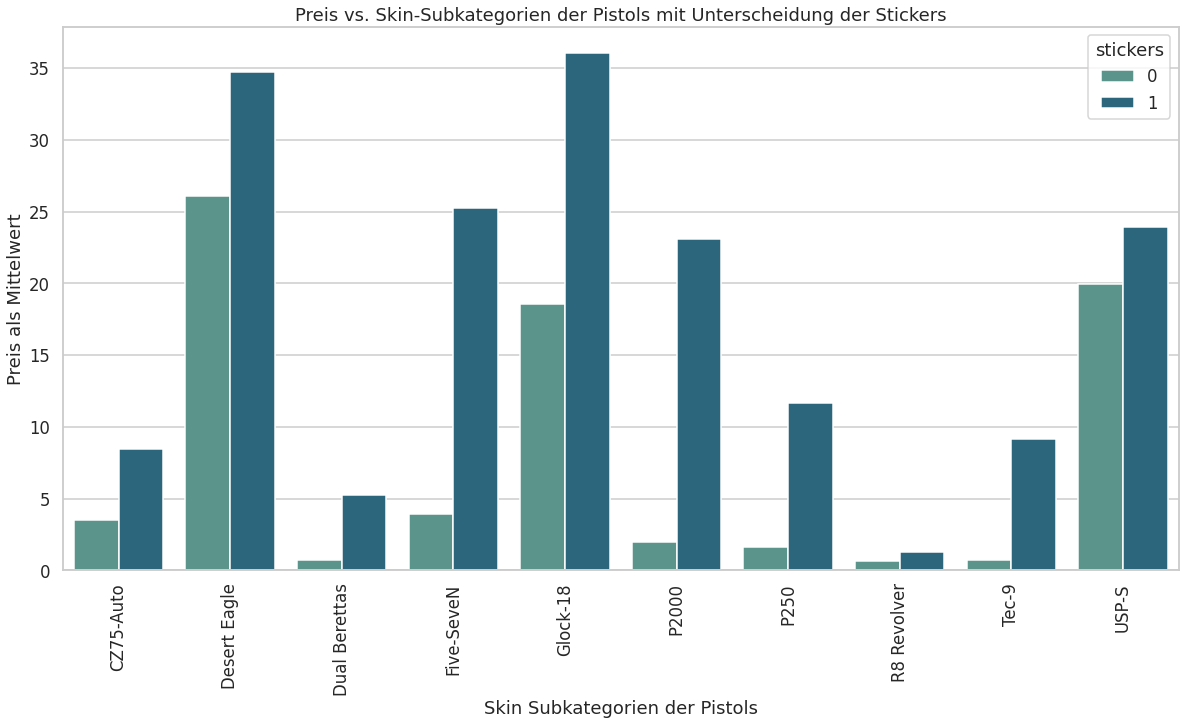

In [ ]:
sns.barplot(data = temp, x='subCategory', y='salePrice', hue='stickers', palette = 'crest'); #Blues_d
plt.xlabel("Skin Subkategorien der Pistols")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. Skin-Subkategorien der Pistols mit Unterscheidung der Stickers")
plt.tick_params(axis='x', rotation=90)

####**souvenir**

Das Feature *quality* beinhaltet bereits alle benötigten Informationen zu *souvenir* dennoch wird *souvenir* hier analysiert.  Für das Modell kann das Feature gelöscht werden. Beweis:

In [ ]:
data.groupby(['souvenir'])['salePrice'].count()

souvenir
0    124309
1      8498
Name: salePrice, dtype: int64

In [ ]:
data.groupby(['quality'])['salePrice'].count()

quality
Normal         105502
Souvenir         8498
StatTrak™       12593
★                5532
★ StatTrak™       682
Name: salePrice, dtype: int64

Die Souvenir-Anzahl aus *quality* und aus *souvenir == 1* ist identisch.

Da Souvenir nur für die Kategorien *Heavy, Pistol, Rifle* und *SMG* existiert, werden die restlichen Kategorien bei dieser betrachtung nicht berücksichtigt.

In [ ]:
data[data.category.isin(['Heavy', 'Pistol', 'Rifle', 'SMG'])].groupby(['category','souvenir'])['salePrice'].mean()

category  souvenir
Heavy     0            2.319551
          1            2.596512
Pistol    0           10.043767
          1            6.687601
Rifle     0           30.437668
          1           39.721963
SMG       0            3.117151
          1            1.984908
Name: salePrice, dtype: float64

In [ ]:
temp = data_smgs.groupby(["subCategory", "souvenir"]).mean().reset_index()
temp = temp[['subCategory', 'souvenir', 'salePrice']]

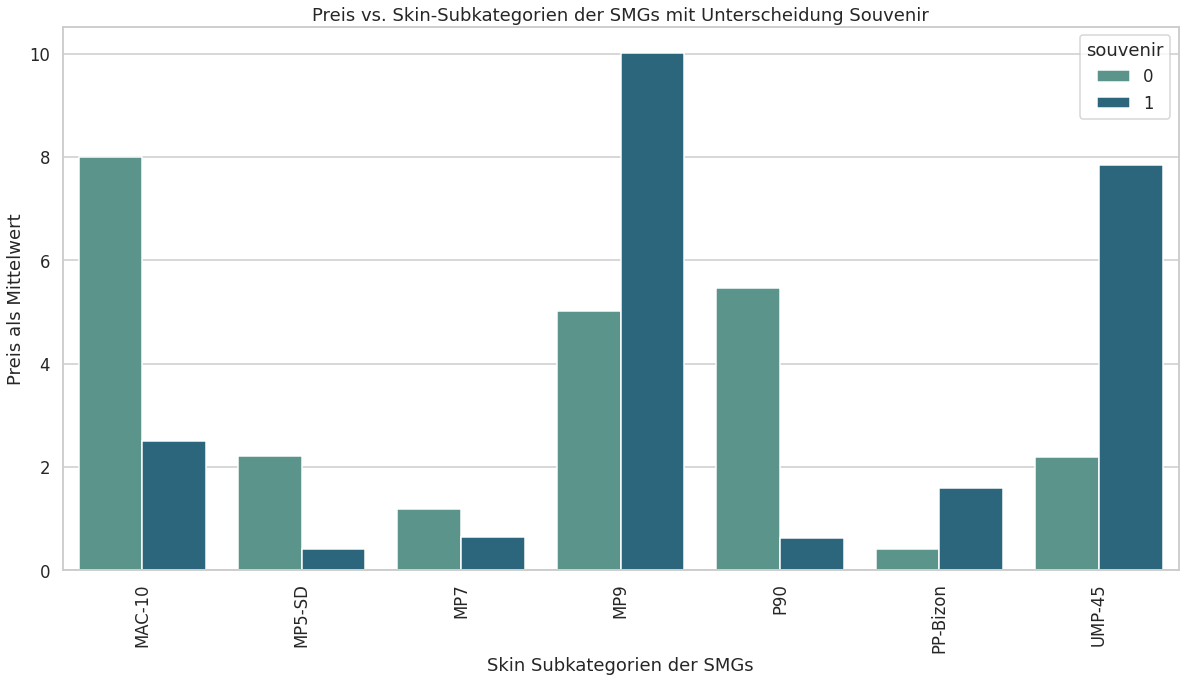

In [ ]:
sns.barplot(data = temp, x='subCategory', y='salePrice', hue='souvenir', palette = 'crest'); #Blues_d
plt.xlabel("Skin Subkategorien der SMGs")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. Skin-Subkategorien der SMGs mit Unterscheidung Souvenir")
plt.tick_params(axis='x', rotation=90)

####**stattrak**

Was für *souvenir* gilt, gilt auch für *stattrak*:
Das Feature *quality* beinhaltet bereits alle benötigten Informationen zu *stattrak* dennoch wird *stattrak* hier analysiert.  Für das Modell kann das Feature gelöscht werden. Beweis:

In [ ]:
data.groupby(['quality'])['salePrice'].count()

quality
Normal         105502
Souvenir         8498
StatTrak™       12593
★                5532
★ StatTrak™       682
Name: salePrice, dtype: int64

In [ ]:
data.groupby(['stattrak'])['salePrice'].count()

stattrak
0    119532
1     13275
Name: salePrice, dtype: int64

Die StatTrak-Anzahl aus *quality (StatTrak + ★ StatTrak)* und aus *stattrak == 1* ist identisch.

Da StatTrak nicht für die Kategorie *Gloves* existiert, werden hierfür die restlichen kategorien betrachtet.

In [ ]:
data.groupby(['category','stattrak'])['salePrice'].mean()

category  stattrak
Gloves    0           310.887998
Heavy     0             2.261401
          1             3.472876
Knife     0           379.475167
          1           492.520220
Pistol    0             8.797683
          1            18.157600
Rifle     0            27.569685
          1            55.669288
SMG       0             2.775974
          1             5.473217
Name: salePrice, dtype: float64

In [ ]:
temp = data_knives.groupby(["subCategory", "stattrak"]).mean().reset_index()
temp = temp[['subCategory', 'stattrak', 'salePrice']]

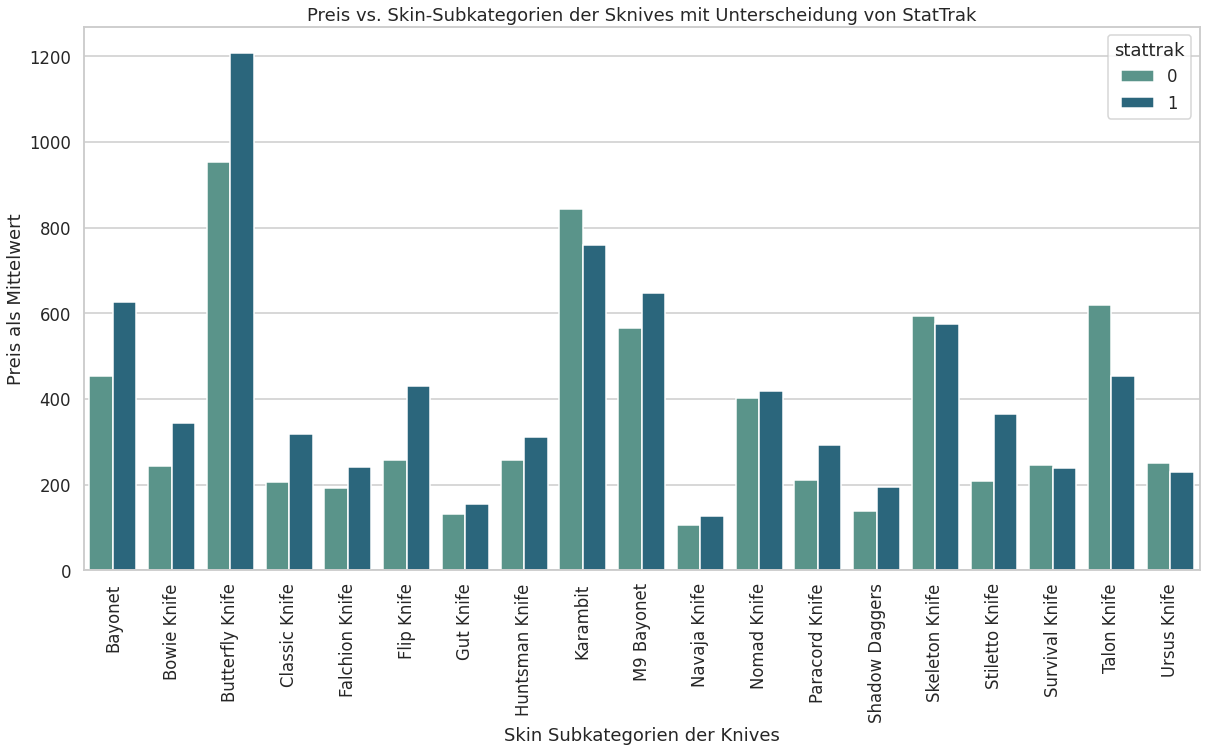

In [ ]:
sns.barplot(data = temp, x='subCategory', y='salePrice', hue='stattrak', palette = 'crest'); #Blues_d
plt.xlabel("Skin Subkategorien der Knives")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. Skin-Subkategorien der Sknives mit Unterscheidung von StatTrak")
plt.tick_params(axis='x', rotation=90)

####**colorfulness**

Text(0.5, 1.0, 'Preise vs. Colorfulness der Skins')

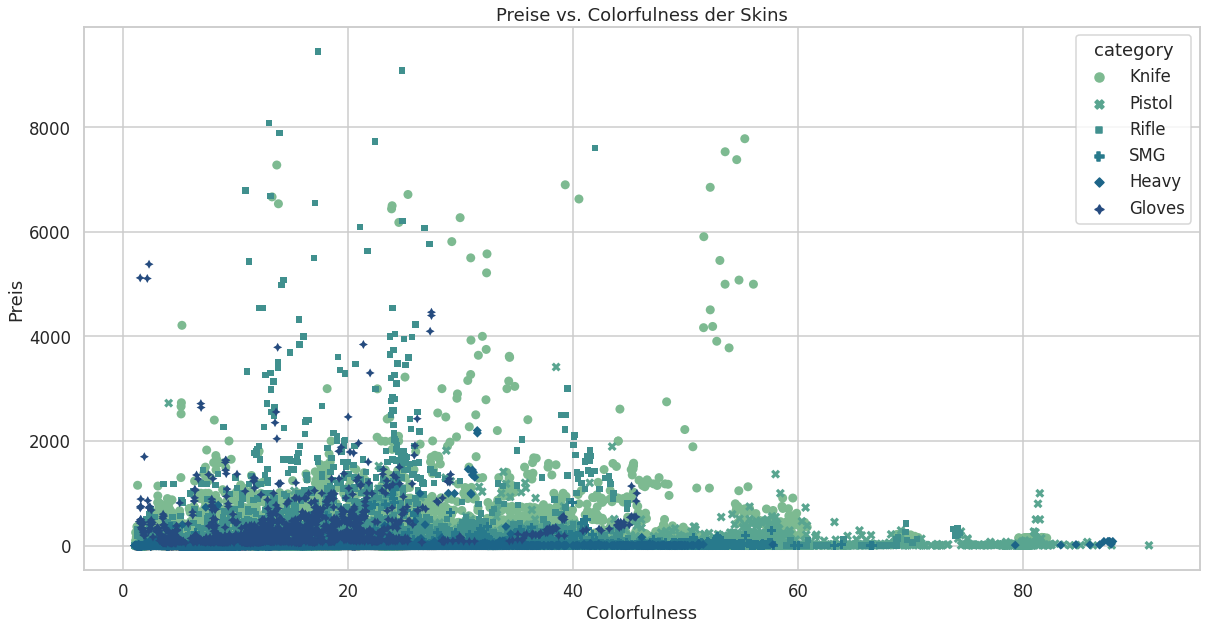

In [ ]:
sns.scatterplot(data = data, x='colorfulness', y='salePrice', hue='category', edgecolor = 'none', palette = 'crest', style = 'category')
plt.xlabel("Colorfulness")
plt.ylabel("Preis")
plt.title("Preise vs. Colorfulness der Skins")

####**cats_colorfulness**

In [ ]:
data.groupby("cats_colorfulness")['salePrice'].count().sort_values()

cats_colorfulness
extemely colorful         28
highly colorful          728
quite colorful          2651
averagely colorful      6042
moderately colorful    38782
slightly colorful      84576
Name: salePrice, dtype: int64

In [ ]:
temp = data.groupby("cats_colorfulness").mean().reset_index()
temp = temp[['cats_colorfulness','salePrice']]
temp = temp.sort_values(by='salePrice', ascending=False)

Text(0.5, 1.0, 'Preis vs. Kategorie Colorfulness')

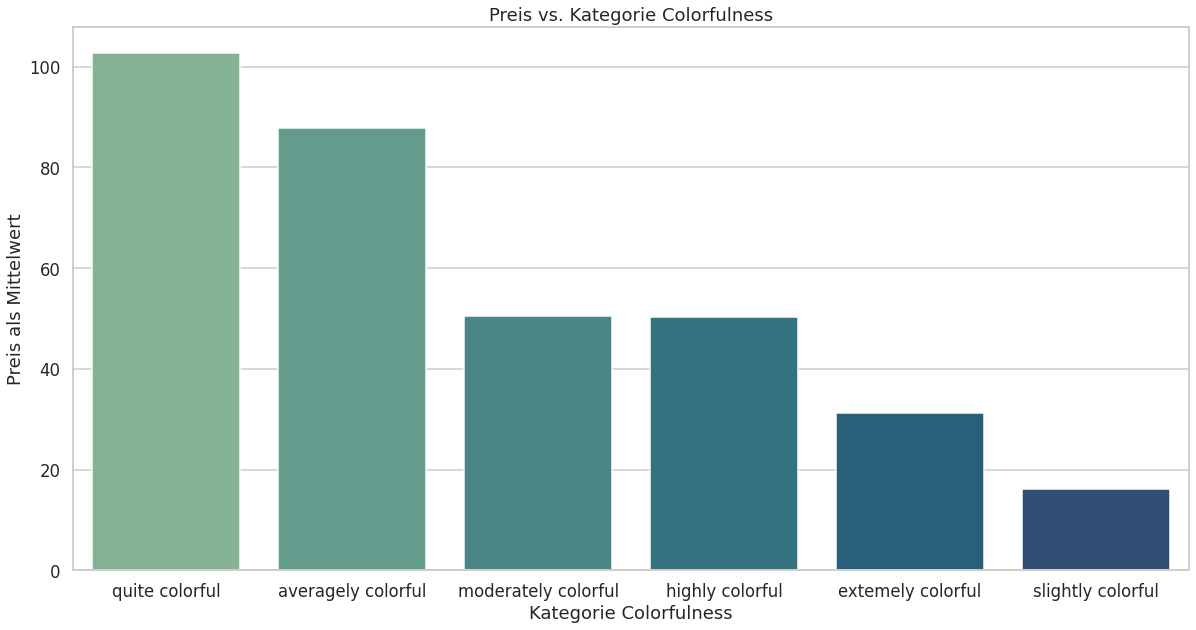

In [ ]:
sns.barplot(data = temp, x='cats_colorfulness', y='salePrice'); 
plt.xlabel("Kategorie Colorfulness")
plt.ylabel("Preis als Mittelwert")
plt.title("Preis vs. Kategorie Colorfulness")

###Speicherpunkt

In [ ]:
# Speicherpunkt 3: Zwischenspeichern der Daten, sodass Prozess nicht immer wieder durchlaufen werden muss
data.to_csv(r'allitems_cleaned_3.csv', index=False, header=True)

In [ ]:
# Ladepunkt 1: Laden der Daten, sodass hier eingestiegen werden kann
data = pd.read_csv(r'/content/drive/MyDrive/SA_BA/Data/allitems_cleaned_3.csv')

###Bilder

#### 5 teuerste Skins

In [ ]:
data.sort_values('salePrice', ascending=False).head(5)

,index,assetId,family,color,lock,version,salePrice,category,subCategory,pattern,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
69242,69427,53910107,Dragon Lore,#D2D2D2,1,default,9446.85,Rifle,AWP,306,...,Factory New,Normal,Covert,#eb4b4b,The Cobblestone Collection,1,0,0,17.303330,moderately colorful
61330,61512,51674383,Howl,#D2D2D2,0,default,9084.75,Rifle,M4A4,482,...,Minimal Wear,Normal,Covert,#eb4b4b,No Collection,1,0,0,24.795722,moderately colorful
59222,59402,52439245,Imminent Danger,#FFD700,0,default,8075.33,Rifle,M4A1-S,601,...,Battle-Scarred,Souvenir,Covert,#eb4b4b,The 2021 Vertigo Collection,1,1,0,12.947537,slightly colorful
69495,69680,58933081,Gungnir,#D2D2D2,0,default,7892.24,Rifle,AWP,94,...,Minimal Wear,Normal,Covert,#eb4b4b,The Norse Collection,0,0,0,13.898583,slightly colorful
2510,2570,25506060,Doppler,#8650AC,0,Sapphire,7777.77,Knife,Karambit,291,...,Minimal Wear,★,Covert,#eb4b4b,No Collection,0,0,0,55.255036,quite colorful


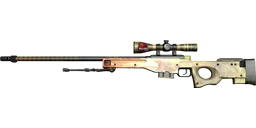

In [ ]:
#1 
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/53910107/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

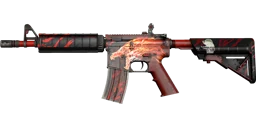

In [ ]:
#2
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/51674383/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

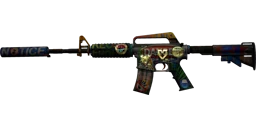

In [ ]:
#3
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/52439245/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

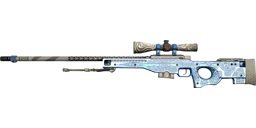

In [ ]:
#4
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/58933081/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

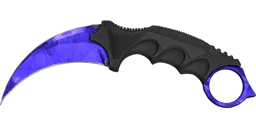

In [ ]:
#5
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/25506060/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

####5 billigste Skins

In [ ]:
data.sort_values('salePrice', ascending=False).tail(5)

,index,assetId,family,color,lock,version,salePrice,category,subCategory,pattern,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
11665,11837,27124015,Colony,#D2D2D2,0,default,0.02,Pistol,Dual Berettas,968,...,Battle-Scarred,Normal,Consumer Grade,#b0c3d9,The Train Collection,0,0,0,13.487862,slightly colorful
11666,11838,31995629,Colony,#D2D2D2,0,default,0.02,Pistol,Dual Berettas,520,...,Field-Tested,Normal,Consumer Grade,#b0c3d9,The Train Collection,0,0,0,18.324941,moderately colorful
11667,11839,31454922,Colony,#D2D2D2,0,default,0.02,Pistol,Dual Berettas,643,...,Well-Worn,Normal,Consumer Grade,#b0c3d9,The Train Collection,0,0,0,15.980488,moderately colorful
37462,37640,21614832,Groundwater,#D2D2D2,0,default,0.02,Pistol,Tec-9,904,...,Field-Tested,Normal,Consumer Grade,#b0c3d9,The Italy Collection,0,0,0,9.844756,slightly colorful
83305,83492,54414858,Prey,#FFD700,0,default,0.02,Rifle,SSG 08,250,...,Field-Tested,Souvenir,Consumer Grade,#b0c3d9,The 2021 Mirage Collection,1,1,0,7.257833,slightly colorful


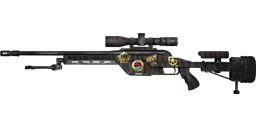

In [ ]:
#1
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/54414858/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

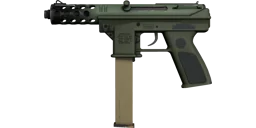

In [ ]:
#2
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/21614832/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

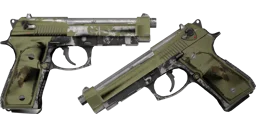

In [ ]:
#3
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/31454922/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

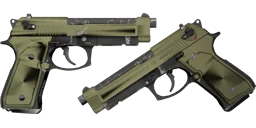

In [ ]:
#4
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/31995629/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

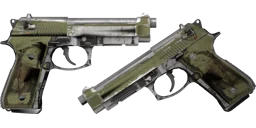

In [ ]:
#5
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/27124015/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

#### Ausgewählte teuerste Skins nach Kategorie (in top 5)

In [ ]:
#Knife
data_knives.sort_values('salePrice', ascending=False).head(5)

,index,assetId,family,color,lock,version,salePrice,category,subCategory,pattern,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
2510,2570,25506060,Doppler,#8650AC,0,Sapphire,7777.77,Knife,Karambit,291,...,Minimal Wear,★,Covert,#eb4b4b,No Collection,0,0,0,55.255036,quite colorful
2527,2587,48110603,Doppler,#8650AC,0,Sapphire,7528.40,Knife,Karambit,748,...,Factory New,★,Covert,#eb4b4b,No Collection,0,0,0,53.509328,quite colorful
2518,2578,39142674,Doppler,#8650AC,0,Sapphire,7377.66,Knife,Karambit,593,...,Factory New,★,Covert,#eb4b4b,No Collection,0,0,0,54.538797,quite colorful
798,820,57366831,Doppler,#8650AC,0,Ruby,7275.07,Knife,Butterfly Knife,168,...,Factory New,★,Covert,#eb4b4b,The Breakout Collection,0,0,0,13.650705,slightly colorful
140,140,44278438,Gamma Doppler,#8650AC,1,Emerald,6897.00,Knife,Bayonet,818,...,Factory New,★ StatTrak™,Covert,#eb4b4b,No Collection,0,0,1,39.294542,averagely colorful


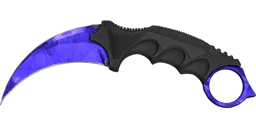

In [ ]:
#Platz 1
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/25506060/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

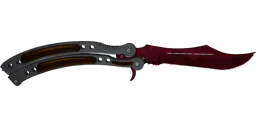

In [ ]:
#Platz 4
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/57366831/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

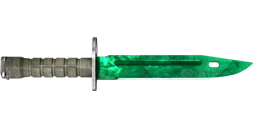

In [ ]:
#Platz 5
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/44278438/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

In [ ]:
#Gloves
data_gloves.sort_values('salePrice', ascending=False).head(5)

,index,assetId,family,color,lock,version,salePrice,category,subCategory,pattern,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
131329,131526,24169138,Black Tie,#8650AC,0,default,5378.35,Gloves,Driver Gloves,343,...,Factory New,★,Extraordinary,#eb4b4b,No Collection,0,0,0,2.296942,slightly colorful
132605,132803,53027469,Nocts,#8650AC,0,default,5117.67,Gloves,Sport Gloves,761,...,Factory New,★,Extraordinary,#eb4b4b,No Collection,0,0,0,1.511169,slightly colorful
131324,131521,59342332,Black Tie,#8650AC,0,default,5105.95,Gloves,Driver Gloves,789,...,Factory New,★,Extraordinary,#eb4b4b,No Collection,0,0,0,2.140389,slightly colorful
132462,132659,53966435,Vice,#8650AC,1,default,4460.74,Gloves,Sport Gloves,71,...,Minimal Wear,★,Extraordinary,#eb4b4b,No Collection,0,0,0,27.402120,moderately colorful
132458,132655,54237346,Vice,#8650AC,0,default,4397.71,Gloves,Sport Gloves,464,...,Minimal Wear,★,Extraordinary,#eb4b4b,No Collection,0,0,0,27.402597,moderately colorful


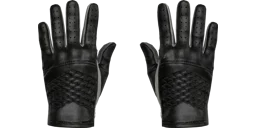

In [ ]:
#Platz 1
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/24169138/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

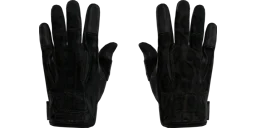

In [ ]:
# Platz 2
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/53027469/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

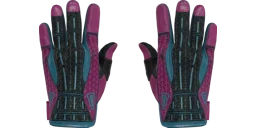

In [ ]:
# Platz 4
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/53966435/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

In [ ]:
#Pistol
data_pistols.sort_values('salePrice', ascending=False).head(5)

,index,assetId,family,color,lock,version,salePrice,category,subCategory,pattern,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
25207,25382,49396146,Splash,#CF6A32,0,default,3413.83,Pistol,P250,240,...,Minimal Wear,StatTrak™,Restricted,#8847ff,The eSports 2013 Collection,1,0,1,38.484080,averagely colorful
7056,7226,59296319,Printstream,#D2D2D2,0,default,2723.47,Pistol,Desert Eagle,15,...,Field-Tested,Normal,Covert,#eb4b4b,The Fracture Collection,0,0,0,4.040428,slightly colorful
7249,7420,19137827,Cobalt Disruption,#D2D2D2,0,default,1893.31,Pistol,Desert Eagle,210,...,Factory New,Normal,Classified,#d32ee6,The eSports 2013 Winter Collection,1,0,0,43.463449,averagely colorful
18619,18793,31745138,Fade,#D2D2D2,1,default,1816.95,Pistol,Glock-18,558,...,Factory New,Normal,Restricted,#8847ff,The Assault Collection,1,0,0,28.720429,moderately colorful
18600,18774,37021410,Fade,#D2D2D2,0,default,1521.70,Pistol,Glock-18,957,...,Minimal Wear,Normal,Restricted,#8847ff,The Assault Collection,0,0,0,22.721747,moderately colorful


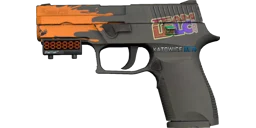

In [ ]:
# Platz 1
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/49396146/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

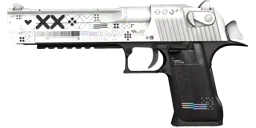

In [ ]:
# Platz 2
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/59296319/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

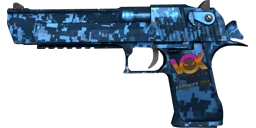

In [ ]:
# Platz 3
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/19137827/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

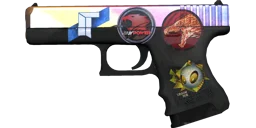

In [ ]:
# Platz 4
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/31745138/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

In [ ]:
#Rifle
data_rifles.sort_values('salePrice', ascending=False).head(5)

,index,assetId,family,color,lock,version,salePrice,category,subCategory,pattern,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
69242,69427,53910107,Dragon Lore,#D2D2D2,1,default,9446.85,Rifle,AWP,306,...,Factory New,Normal,Covert,#eb4b4b,The Cobblestone Collection,1,0,0,17.303330,moderately colorful
61330,61512,51674383,Howl,#D2D2D2,0,default,9084.75,Rifle,M4A4,482,...,Minimal Wear,Normal,Covert,#eb4b4b,No Collection,1,0,0,24.795722,moderately colorful
59222,59402,52439245,Imminent Danger,#FFD700,0,default,8075.33,Rifle,M4A1-S,601,...,Battle-Scarred,Souvenir,Covert,#eb4b4b,The 2021 Vertigo Collection,1,1,0,12.947537,slightly colorful
69495,69680,58933081,Gungnir,#D2D2D2,0,default,7892.24,Rifle,AWP,94,...,Minimal Wear,Normal,Covert,#eb4b4b,The Norse Collection,0,0,0,13.898583,slightly colorful
43533,43713,59055618,Case Hardened,#CF6A32,0,default,7722.04,Rifle,AK-47,48,...,Minimal Wear,StatTrak™,Classified,#d32ee6,The Arms Deal Collection,1,0,1,22.409175,moderately colorful


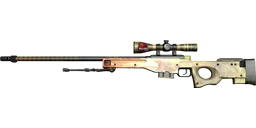

In [ ]:
# Platz 1
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/53910107/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

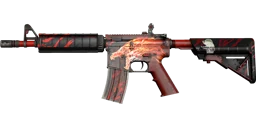

In [ ]:
# Platz 2
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/51674383/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

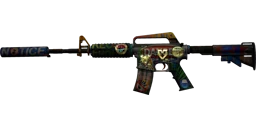

In [ ]:
# Platz 3
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/52439245/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

In [ ]:
#SMG
data_smgs.sort_values('salePrice', ascending=False).head(5)

,index,assetId,family,color,lock,version,salePrice,category,subCategory,pattern,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
95460,95651,53616749,Wild Lily,#D2D2D2,0,default,1189.27,SMG,MP9,562,...,Factory New,Normal,Classified,#d32ee6,The St. Marc Collection,0,0,0,24.358969,moderately colorful
95467,95658,47261046,Wild Lily,#D2D2D2,0,default,1081.43,SMG,MP9,41,...,Minimal Wear,Normal,Classified,#d32ee6,The St. Marc Collection,0,0,0,24.102978,moderately colorful
95463,95654,53549870,Wild Lily,#D2D2D2,0,default,975.00,SMG,MP9,387,...,Minimal Wear,Normal,Classified,#d32ee6,The St. Marc Collection,0,0,0,23.847440,moderately colorful
95461,95652,52547466,Wild Lily,#D2D2D2,0,default,900.00,SMG,MP9,79,...,Minimal Wear,Normal,Classified,#d32ee6,The St. Marc Collection,0,0,0,24.011466,moderately colorful
95465,95656,30596689,Wild Lily,#D2D2D2,1,default,828.52,SMG,MP9,387,...,Minimal Wear,Normal,Classified,#d32ee6,The St. Marc Collection,0,0,0,24.088505,moderately colorful


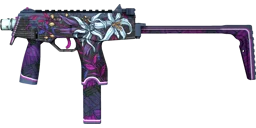

In [ ]:
# Platz 1
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/53616749/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

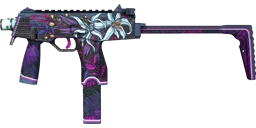

In [ ]:
# Platz 2
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/47261046/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

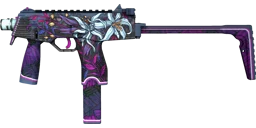

In [ ]:
# Platz 5
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/30596689/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

In [ ]:
#Heavy
data_heavy.sort_values('salePrice', ascending=False).head(5)

,index,assetId,family,color,lock,version,salePrice,category,subCategory,pattern,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
129248,129444,40742922,Mjölnir,#D2D2D2,0,default,2200.00,Heavy,Negev,511,...,Factory New,Normal,Classified,#d32ee6,The Norse Collection,0,0,0,31.474104,moderately colorful
129247,129443,40742923,Mjölnir,#D2D2D2,0,default,2150.00,Heavy,Negev,712,...,Factory New,Normal,Classified,#d32ee6,The Norse Collection,0,0,0,31.485562,moderately colorful
129245,129441,30810914,Mjölnir,#D2D2D2,0,default,1459.24,Heavy,Negev,204,...,Minimal Wear,Normal,Classified,#d32ee6,The Norse Collection,0,0,0,30.670917,moderately colorful
129246,129442,51022250,Mjölnir,#D2D2D2,0,default,1445.00,Heavy,Negev,562,...,Factory New,Normal,Classified,#d32ee6,The Norse Collection,0,0,0,31.047007,moderately colorful
129243,129439,26545877,Mjölnir,#D2D2D2,0,default,1400.00,Heavy,Negev,355,...,Factory New,Normal,Classified,#d32ee6,The Norse Collection,0,0,0,31.136358,moderately colorful


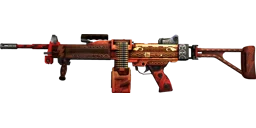

In [ ]:
# Platz 1
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/40742922/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

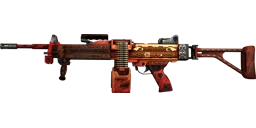

In [ ]:
# Platz 3
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/30810914/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

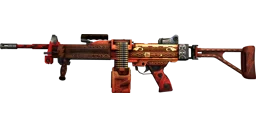

In [ ]:
# Platz 5
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/26545877/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im